# 股票投資分析與程式設計 - 期末個人報告
報告者：賴冠霖


*** [報告PPT點這裡下載](https://docs.google.com/presentation/d/1S9sYV5fKOlMZ8S3ObbSnGT5xufb3-Oky/edit?usp=sharing&ouid=117056313411217753618&rtpof=true&sd=true)**

<h1>目錄<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#基本設置" data-toc-modified-id="基本設置-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>基本設置</a></span></li><li><span><a href="#技術指標模塊" data-toc-modified-id="技術指標模塊-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>技術指標模塊</a></span></li><li><span><a href="#策略模塊" data-toc-modified-id="策略模塊-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>策略模塊</a></span></li><li><span><a href="#回測模塊" data-toc-modified-id="回測模塊-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>回測模塊</a></span></li><li><span><a href="#繪圖模塊" data-toc-modified-id="繪圖模塊-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>繪圖模塊</a></span></li><li><span><a href="#新欄位添加模塊" data-toc-modified-id="新欄位添加模塊-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>新欄位添加模塊</a></span></li><li><span><a href="#資料寫入Excel模塊" data-toc-modified-id="資料寫入Excel模塊-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>資料寫入Excel模塊</a></span></li><li><span><a href="#Excel-Sheet-清空模塊" data-toc-modified-id="Excel-Sheet-清空模塊-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Excel Sheet 清空模塊</a></span></li><li><span><a href="#執行回測並搜集資料" data-toc-modified-id="執行回測並搜集資料-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>執行回測並搜集資料</a></span></li><li><span><a href="#測試日資料" data-toc-modified-id="測試日資料-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>測試日資料</a></span></li><li><span><a href="#總結---日資料" data-toc-modified-id="總結---日資料-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>總結 - 日資料</a></span></li><li><span><a href="#測試高頻資料" data-toc-modified-id="測試高頻資料-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>測試高頻資料</a></span></li><li><span><a href="#總結---高頻資料" data-toc-modified-id="總結---高頻資料-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>總結 - 高頻資料</a></span></li><li><span><a href="#Q&amp;A" data-toc-modified-id="Q&amp;A-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Q&amp;A</a></span></li></ul></div>

## 基本設置

1. 標的選擇：從台灣50指數當中的成分股，挑選出以下15個產業中，各個持股比例最大的上市股票標的。  

* 半導體業：台積電 2330  
* 電子業：鴻海 2317  
* 通信網路業：宏達電 2409  
* 塑膠工業：台塑 1301  
* 金融保險業：國泰金 2883  
* 鋼鐵工業：中鋼 2002  
* 光電業：奇美電子 2337   
* 電子零組件業：台達電 2308  
* 電腦及週邊設備業：宏碁 2353   
* 油電燃氣業：台塑石化 1314  
* 食品工業：統一 1216  
* 紡織纖維：遠東新 1326  
* 水泥工業：台泥 1101  
* 電子通路業：聯強國際 2337   
* 貿易百貨：統一超 1229  



2. 資料頻率與期間：日資料，自2013年01月01日 至2023年01月01日。
3. 資料來源：Yahoo Finance，透過yfinance套件抓取。
4. 手續費成本：買賣股票時，手續費依成交金額的0.1425％計收。

In [9]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from datetime import datetime
import seaborn as sb
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
import math
from pathlib import Path
import numpy as np
import pandas as pd
import mplfinance as mpf
from datetime import datetime

## 技術指標模塊

In [10]:
def MA(_ticker, period=10, field='Close'):

    '''_ticker 應為 dataframe 型別
        period 設定應為幾日之均線
        field 設定要哪一欄資料的均線
    '''
    
    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)
    
    if field == 'Volume':
        res['VMA_' + str(period)] = _ticker[field].rolling(period).mean()

    else:
        res['MA_' + str(period)] = _ticker[field].rolling(period).mean()

    return res

def RSI(_ticker, period = 14):
    
    # 創建空 dataframe 供計算暫存用(其index內容與 ticker 相同)
    tmp = pd.DataFrame(index=_ticker.index)

    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)
    
    # 新增 rise 欄位，預設為空
    tmp['rise'] = np.nan

    # 搜尋特定欄位之 index
    col_rise = tmp.columns.get_loc('rise')
    col_close = _ticker.columns.get_loc('Close')

    # 計算今日漲跌數字
    for i in range(1, len(_ticker)):
        tmp.iloc[i, col_rise] = _ticker.iloc[i, col_close] - _ticker.iloc[i - 1, col_close]
    
    # 創建空資料欄
    tmp['rise_only'] = tmp['rise']
    tmp['drop_only'] = tmp['rise']

    # 依照數值大小於零分堆
    tmp['rise_only'].loc[tmp['rise'] < 0] = 0
    tmp['drop_only'].loc[tmp['rise'] > 0] = 0
    
    # 計算 N 天內平均漲跌數值
    tmp['rise_avg'] = tmp['rise_only'].rolling(period, min_periods=1).mean()
    tmp['drop_avg'] = tmp['drop_only'].rolling(period, min_periods=1).mean().abs()

    # 計算 RSI
    res['RSI'] = tmp['rise_avg'] / (tmp['rise_avg'] + tmp['drop_avg']) * 100
    
    return res

def KD(_ticker, period = 9):
# _ticker = ticker
    # 創建暫存資料
    tmp = pd.DataFrame(index=_ticker.index)

    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)

    # 尋找 N 日內最高最低價
    tmp['max_close'] = _ticker['Close'].rolling(period, min_periods=1).max()
    tmp['min_close'] = _ticker['Close'].rolling(period, min_periods=1).min()

    # 計算 RSI
    tmp['RSV'] = (_ticker['Close'] - tmp['min_close']) / (tmp['max_close'] - tmp['min_close']) * 100
    tmp['RSV'] = tmp['RSV'].fillna(0) #0104新增 避免NAN值
    # 由於 K D 之定義為遞迴式，且數值為 0 ~ 100，預設為 50
    res['K'] = 50
    res['D'] = 50
    
    # 計算 K 與 D 值(skip 1，不然會取到 out of range 的數值)
    for i in range(1, len(_ticker)):
        res.loc[res.index[i], 'K'] \
            = res.loc[res.index[i - 1], 'K'] * (2 / 3) + tmp.loc[tmp.index[i], 'RSV'] * (1 / 3)
        res.loc[res.index[i], 'D'] \
            = res.loc[res.index[i - 1], 'D'] * (2 / 3) + res.loc[res.index[i], 'K'] * (1 / 3)
    
    return res

def MACD(_ticker, signal_period=9, fast_period=12, slow_period=26):
    
    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)

    # 計算快慢 EMA
    ema_f = _ticker['Close'].ewm(span=fast_period, adjust=False).mean()
    ema_s = _ticker['Close'].ewm(span=slow_period, adjust=False).mean()
    
    # 計算 MACD 值
    res['macd_dif'] = ema_f - ema_s
    res['macd_dem'] = res['macd_dif'].ewm(span=signal_period, adjust=False).mean()
    res['macd_bar'] = res['macd_dif'] - res['macd_dem']

    return res

## 策略模塊

In [11]:
def strategy_1(_ticker,rsi_trigger = 50,kd_buy_trigger = 20,kd_sell_trigger = 80,macd_trigger = 0):

    _ticker['buy'] = np.zeros(_ticker.shape[0])
    _ticker['sell'] = np.zeros(_ticker.shape[0])

    for i in range(1, _ticker.shape[0]):
        
        # 買入時機
        if (_ticker.loc[_ticker.index[i], 'RSI'] > rsi_trigger #1
 
            and _ticker.loc[_ticker.index[i], 'D'] < kd_buy_trigger  #2

            and _ticker.loc[_ticker.index[i], 'macd_bar'] > macd_trigger  #3
 
            
            
            ):

            _ticker.loc[_ticker.index[i], 'buy'] = 1   

        # 賣出時機
        if (_ticker.loc[_ticker.index[i], 'RSI'] < rsi_trigger #1
  
            and _ticker.loc[_ticker.index[i], 'D'] > kd_sell_trigger  #2
  
            and _ticker.loc[_ticker.index[i], 'macd_bar'] < macd_trigger  #3
 
            ):

            _ticker.loc[_ticker.index[i], 'sell'] = 1


    return _ticker

## 回測模塊

In [12]:
# 回測模塊
def backtest(_ticker):
    # 假設每個買點最多買一張，遇到賣點會將手中持股全數賣出

    # 目前持有數量
    stock_num = 0
    # 每次購入張數
    unit = 1

    # 目前獲利
    gain = 0
    # 目前投資報酬率
    return_rate = 1
    # 為了計算投資報酬率
    balance = 0

    # 為了計算勝率
    make_money = 0
    trade_times = 0

    # 紀錄交易資訊
    detail = [['日期', '買/賣(+/-)', '價格', '價格(稅)', '實際花費', '目前獲利', '此次投報', '目前投報']]

    # 迭帶 SData 中的每一列資料
    for index, row in _ticker.iterrows():

        # 遇到買點就買入一張
        if row['buy'] == 1 and index != _ticker.index[-1]:

            # 日期(會將時間戳記轉為字串，第二個參數可以設定樣式)
            date = datetime.strftime(index, '%m/%d')
            # 買賣數量(將持有股票全部賣出)
            _unit = f'+{unit}'
            # 買入價格(假設為當日盤後買收盤價)
            _price = row['Close']
            # 買入價格(含稅)
            _price_tax = round(row['Close'] * 1.001425, 1)
            # 實際總花費
            total_cost = round(row['Close'] * 1.001425 * unit * 1000) * -1
            # 淨收益計算
            gain += total_cost
            # 更新下次投資報酬之現金平衡
            balance += total_cost
            # 更新持有數量
            stock_num += unit

            # 將此列交易資訊加入 detail 中
            detail.append([date, _unit, _price, _price_tax, total_cost, gain, 'NaN', return_rate])

        # 遇到賣點全數賣出
        # 是最後一天且還持有股票時，無條件賣出，方便計算投資報酬率
        elif (row['sell'] == 1 and stock_num > 0) or (index == _ticker.index[-1] and stock_num > 0):
            
            # 日期(會將時間戳記轉為字串，第二個參數可以設定樣式)
            date = datetime.strftime(index, '%m/%d')
            # 買賣數量(將持有股票全部賣出)
            _unit = f'-{stock_num}'
            # 賣出價格(假設為當日盤後買收盤價)
            _price = row['Close']
            # 賣出價格(含稅)(四捨五入到小術後一位)
            _price_tax = round(row['Close'] * 0.995575, 1)
            # 實際總花費(四捨五入到整數位)
            total_cost = round(row['Close'] * 0.995575 * stock_num * 1000)
            # 淨收益計算
            gain += total_cost
            # 更新投資報酬率
            principal = -balance
            balance += total_cost
            current_return = 1 + (balance / principal)
            return_rate *= 1 + (balance / principal)
            # to calculate accuracy
            trade_times += 1
            if(balance > 0):
                make_money += 1
            # 重製 balance
            balance = 0
            # 更新持有數量
            stock_num = 0
            
            # 將此列交易資訊加入 detail 中
            detail.append([date, _unit, _price, _price_tax, total_cost, gain, current_return, return_rate])

    #新增 買入持有策略績效 - 投資報酬率
    first = _ticker['Close'][0]
    last = _ticker['Close'][len(_ticker)-1]
    cumulative_exret = (last-first)/first
    cumulative_exret = round(cumulative_exret*100 , 2)
    #print("買入持有投資報酬率：", cumulative_exret, "%")     
    
    
    # 淨收益、投資報酬率、
    # print("淨收益：", detail[-1][5], "元")
    # print("投資報酬率：", (return_rate - 1) * 100, "%")
    # if(trade_times != 0):
    #     print('勝率 :', make_money / trade_times * 100, '%')
    if(trade_times != 0):
        acc = make_money / trade_times * 100
    else:
        acc = -1
    
 
    return pd.DataFrame(detail[1:], columns=detail[0]), acc, cumulative_exret

## 繪圖模塊

In [13]:
def plot(_ticker, _title='', volume=True, buy_sell_point=False, 
    RSI=False, rsi_midline=False, rsi_bound=False, rsi_upper_bound=85, rsi_lower_bound=15, 
    KD=False, kd_bound=False, kd_upper_bound=85, kd_lower_bound=15, 
    MACD=False, BBands=False):

    apds = []
    _panel = 1

    # 繪製買賣點，並判斷繪圖範圍內是否存在買賣點，避免出錯
    if buy_sell_point:
        
        buy, sell = [], []

        # 在K線圖上標記買賣點，且避免遮擋到 K 線
        for index, row in _ticker.iterrows():
            if row['buy'] == 1:
                buy.append(row['Close'] * 0.98)
            else:
                buy.append(np.nan)
            if row['sell'] == 1:
                sell.append(row['High'] * 1.02)
            else:
                sell.append(np.nan)

        if np.count_nonzero(np.isnan(sell)) != len(sell):
            apds.append(mpf.make_addplot(sell , type = 'scatter', color = 'red', marker = 'v', markersize = 100))
        if np.count_nonzero(np.isnan(buy)) != len(buy):
            apds.append(mpf.make_addplot(buy , type = 'scatter', color = '#cfc01d', marker = '^', markersize = 200))

    # 加入 RSI 指標
    if RSI:

        _panel += 1
        apds += [ 
            mpf.make_addplot(_ticker['RSI'], panel = _panel - 1, color='#009393', ylabel='RSI', secondary_y=False)
        ]

        # 加入上下界線
        if rsi_bound:
            apds += [
                mpf.make_addplot(np.full((len(_ticker)), rsi_lower_bound), 
                    panel = _panel - 1, color='#F00078', alpha=0.5, secondary_y=False),
                mpf.make_addplot(np.full((len(_ticker)), rsi_upper_bound), 
                    panel = _panel - 1, color='#F00078', alpha=0.5, secondary_y=False)
            ]

        # 加入中線
        if rsi_midline:
            apds += [mpf.make_addplot(np.full((len(_ticker)), 50), 
                    panel = _panel - 1, color='#F00078', alpha=0.5)]

    # 加入 KD 指標
    if KD:

        _panel += 1
        apds += [ 
            mpf.make_addplot(_ticker['K'], panel=_panel - 1, color='#0000C6', 
                ylabel='KD'),
            mpf.make_addplot(_ticker['D'], panel=_panel - 1, color='#F75000'),
            ]

        # 加入上下界線
        if kd_bound:
            apds += [
                mpf.make_addplot(np.full((len(_ticker)), kd_upper_bound), 
                    panel=_panel - 1, color='#F00078', alpha=0.5, secondary_y=False),
                mpf.make_addplot(np.full((len(_ticker)), kd_lower_bound), 
                    panel=_panel - 1, color='#F00078', alpha=0.5, secondary_y=False)
            ]

    # 加入 MACD
    if MACD:

        _panel += 1
        apds += [
            mpf.make_addplot(_ticker['macd_bar'], type='bar', ylabel='MACD', width=0.7, panel=_panel - 1,
                color='dimgray', alpha=1, secondary_y=False),
            mpf.make_addplot(_ticker['macd_dif'], panel=_panel - 1, color='fuchsia', secondary_y=False),
            mpf.make_addplot(_ticker['macd_dem'], panel=_panel - 1, color='b', secondary_y=False)
        ]

    # 如果要加成交量，層數加一
    if volume:
        _panel += 1

    # 加入布林帶
    if BBands:
        apds += [
            mpf.make_addplot(_ticker['bbands_middle'], panel=0, color='#9F4D95', alpha=1, width=1, secondary_y=False),
            mpf.make_addplot(_ticker['bbands_upper'], panel=0, color='black', alpha=0.5, width=0.8, secondary_y=False),
            mpf.make_addplot(_ticker['bbands_lower'], panel=0, color='black', alpha=0.5, width=0.8, secondary_y=False),
           
        ]

    # 設置k線圖顏色
    my_color = mpf.make_marketcolors(up='red',      # 上漲顏色
                                     down='green',  # 下跌顏色
                                     edge='i',      # 隱藏 K 線邊緣
                                     volume='in',   # 成交量用同樣的顏色
                                     inherit=True)  # 繼承其他參數

    # 設置圖型呈現
    my_style = mpf.make_mpf_style(gridaxis='both',          # 設置網格
                                  gridstyle='-.',           # 設定網格花樣
                                  y_on_right=True,          # y 座標放右邊
                                  marketcolors=my_color)    # 設定k線圖顏色

    mpf.plot(_ticker, 
        type='candle',              # 設定要繪製的類別
        num_panels=_panel,          # 設定總層數
        main_panel=0,               # 設定 K 線圖層數
        volume=volume,              # 設定是否繪製成交量 
        volume_panel=_panel - 1,    # 設定成交量層數
        addplot = apds,             # 加入其他數據
        figscale=1.5,               # 設定圖型大小
        style=my_style,             # 設定圖型呈現
        title=_title,               # 設定 title
        show_nontrading=False,      # 忽略非交易日
        tight_layout=False          # 設定布局方式
        )
    return

## 新欄位添加模塊
添加新欄位到df，這邊我們新增 "股票標的中文名稱"(name)跟 "產業"(industries) 這兩個欄位到dataframe中。

In [14]:
#添加新欄位模塊
def df_add(_df,name=None,industries=None):
    if name==None and industries==None:
        industries = ["半導體業", "電子業", "通信網路業", "塑膠工業", "金融保險業", "鋼鐵工業",
                      "光電業", "電子零組件業", "電腦及週邊設備業", "油電燃氣業", "食品工業", "紡織纖維", 
                      "水泥工業", "電子通路業", "貿易百貨","ETF"]

        name = ["台積電", "鴻海", "宏達電", "台塑", "國泰金", "中鋼", "奇美電子", "台達電", "宏碁", 
                     "台塑石化", "統一", "遠東新", "台泥", "聯強國際", "統一超","台灣50指數"]

    _df['industries'] = industries
    # Add the list as the first column in the DataFrame
    _df.insert(0, 'name', name)
    
    return _df

## 資料寫入Excel模塊
將交易資訊寫入Excel裡面，Export(Add) Pandas dataframes to (existing) Excel workbook

In [67]:
import pandas as pd
# You can also write multiple DataFrames to a single sheet.
# Note that the if_sheet_exists parameter needs to be set to overlay (預設是if_sheet_exists='replace')

def df_to_excel(my_df,excel_path,sheet_name, startcol = 0,header = True,row_change_bar = 12):
    
 
    # Task1: Firstly, we need to check if it's a existing sheet_name in your excel file
    # step1: Load the Excel file
    my_excel = pd.read_excel(excel_path, sheet_name=None)
    # step2:Get the list of sheet names
    sheet_names = my_excel.keys()
    # step3: now check if it's a existing sheet_name in your excel file
    if sheet_name in sheet_names: 
        excel_sheet = pd.read_excel(excel_path, sheet_name=sheet_name) #看一下當前sheet裡面資料的shape維度
        exist_col = excel_sheet.shape[1] #看當前資料的column數量
        #設定新資料的column寫入位置(startcol)，要避免和現有資料column重疊
        #因此我們將新資料的column(startcol)設定為現有資料column數位置+1=>避免之後要寫入的新資料覆蓋掉已存在當前sheet裡面的資料
        startcol = exist_col + 1
 
    # Task2: Append to an existing Excel file(sheet)
    with pd.ExcelWriter(excel_path, mode='a', engine='openpyxl', if_sheet_exists='overlay') as writer:   
        my_df.to_excel(writer, sheet_name = sheet_name, startcol = startcol, header = header)     

## Excel Sheet 清空模塊
* 模塊用於初始化我們的Excel Sheet
* To clear all the sheets in an existing Excel workbook, and delete the sheets themselve.

In [37]:
import openpyxl

def clear_excelsheet(_excel_path):
    # Create a new workbook, and 覆蓋 the old one
    workbook = openpyxl.Workbook()
    # Save the workbook
    workbook.save(_excel_path)

## 執行回測並搜集資料
### 完整版實作

#### 進行兩件任務：  
* 進行交易策略回測，並輸出結果 
* 建立簡單投資數據報告：將交易策略結果報告"有系統地"自動化輸出至excel檔案

#### 參數說明：
* ticks：標的
* start：資料起始日，If not using period – in the format (yyyy-mm-dd) or datetime.
* end：資料終止日，in the format (yyyy-mm-dd) or datetime.
* period：data period to download (either use period parameter or use start and end) 
* interval：資料頻率，data period to download (either use period parameter or use start and end)，Valid periods are:
“1d”, “5d”, “1mo”, “3mo”, “6mo”, “1y”, “2y”, “5y”, “10y”, “ytd”, “max”
* excel_path：將交易資訊寫入excel檔案，這邊填入檔案位置，預設為"無"(None)。

In [73]:
# get data from yfinance
import yfinance as yf
    
def 完整版實作(ticks,start='2013-01-01',end='2023-01-01',period='max' ,interval='1d',excel_path=None):
    
    #清空所有data，初始化excel檔案
    if excel_path != None:
        clear_excelsheet(excel_path)
             
    final_detail = [['code', 'return rate', 'accuracy','Buy&Hold return rate']]
    
    for t_code in ticks:

        gld = yf.download(t_code,start=start, end=end,period = period,interval = interval)
        #gld = yf.download(t_code,start=start, end=end)
        #gld = yf.download(t_code,period='60d',interval='5m') #測試高頻資料
        gld['Volume'] =  gld['Volume'] //1000 #股數轉張數
        #print(grid)
        ticker = gld

        # 計算技術指標
        # 參數分別是 data, MA_n
        ticker = MA(ticker, 5)
        ticker = MA(ticker, 10)
        # 參數分別是 data, RSI_n
        ticker = RSI(ticker, 6)
        # 參數分別是 data, KD_n
        ticker = KD(ticker, 9)
        # 參數分別是 data, macd_n, quick_ema, slow_ema
        ticker = MACD(ticker, 9, 12, 26) 
        print(ticker.tail())

        # 計算交易策略
        ticker = strategy_1(ticker)

        # 繪圖
        plot(ticker.tail(100), _title='', volume=False, buy_sell_point=True, 
        RSI=True, rsi_midline=True, rsi_bound=False, rsi_upper_bound=0, rsi_lower_bound=100, 
        KD=True, kd_bound=True, kd_upper_bound=80, kd_lower_bound=20, 
        MACD=True, BBands=False)

        # 取得交易資訊
        detail, acc, cumulative_exret = backtest(ticker)
        #印出績效資訊
        if  detail.shape[0] != 0: #處理當標的沒有交易產生的狀況
            淨收益 = detail.iloc[-1, 5]
            print("淨收益：", 淨收益, "元")
            r_rate = round((detail.iloc[-1, 6] - 1) * 100, 2)
            print("投資報酬率：", r_rate, "%")
            print('勝率 :', acc, '%')
            print("買入持有策略_投資報酬率：", cumulative_exret , "%")
            print(detail.tail(10))

            # 紀錄 return rate and accuracy
            final_detail.append([t_code, f'{r_rate} %', f'{round(acc, 2)} %', f'{cumulative_exret} %'])

        else:
            淨收益 = 'NaN'
            r_rate = 'NaN'
            acc = 'NaN'
            print("淨收益：",淨收益, "元")
            print("投資報酬率：", r_rate, "%")
            print('勝率 :', acc, '%')
            print("買入持有策略_投資報酬率：",  cumulative_exret  , "%")
            # 紀錄 return rate and accuracy
            final_detail.append([t_code, f'{r_rate} %', f'{acc} %', f'{cumulative_exret} %'])
        
        #創造(績效資訊) dataframe
        df_tradeinfo = [[t_code,'淨收益(元)', '投資報酬率', '勝率','買入持有策略_投資報酬率']]
        df_tradeinfo.append(['', 淨收益, f'{r_rate} %', f'{acc} %', f'{cumulative_exret} %'])
        df_tradeinfo = pd.DataFrame(df_tradeinfo[1:], columns=df_tradeinfo[0])
        df_tradeinfo = df_tradeinfo.transpose()
        
        #Name the index name of the detail(交易資訊) dataframe
        detail.index.name = t_code
        
        #績效資訊、交易資訊寫入excel檔案
        if excel_path != None:
            #績效資訊
            df_to_excel(df_tradeinfo, excel_path = excel_path, sheet_name = '統整(Overview)', startcol=0,header = False)
            df_to_excel(df_tradeinfo, excel_path = excel_path, sheet_name = t_code, startcol=0,header = False)
            #交易資訊
            df_to_excel(detail, excel_path = excel_path, sheet_name = t_code, startcol=0)

        print('---------------------------------------------------------------------------------')



    df = pd.DataFrame(final_detail[1:], columns=final_detail[0])
    
    #總結寫入excel檔案
    #if excel_path != None:
        #df_to_excel(df, excel_path = excel_path, sheet_name = '統整2(Overview)', startcol=0)
        
    return df 

## 測試日資料 

In [70]:
ticks = ["2330.TW", "2317.TW", "2409.TW", "1301.TW", "2882.TW", "2002.TW",
        "2337.TW", "2308.TW", "2353.TW", "1314.TW", "1216.TW", "1326.TW", 
        "1101.TW", "2337.TW", "1229.TW","0050.TW"]

excel_path = '股投期末報告_賴冠霖.xlsx'

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close  Volume   MA_5   MA_10  \
Date                                                                       
2022-12-26  454.0  457.0  453.5  456.5      456.5    8793  459.2  466.60   
2022-12-27  458.0  462.5  457.0  457.0      457.0   10264  459.1  465.15   
2022-12-28  451.0  452.0  446.0  451.0      451.0   32578  457.5  462.20   
2022-12-29  444.0  449.5  442.5  446.0      446.0   23020  453.1  458.75   
2022-12-30  455.0  456.5  448.5  448.5      448.5   21683  451.8  456.50   

                  RSI          K          D  macd_dif  macd_dem  macd_bar  
Date                                                                       
2022-12-26  31.168831  11.261098  14.293556 -0.244452  4.264265 -4.508716  
2022-12-27  36.231884  10.121778  12.902963 -0.971666  3.217078 -4.188745  
2022-12-28  39.682540   6.747852  10.851259 -2.008981  2.171867 -4.180847  
2022-12-29  31.428

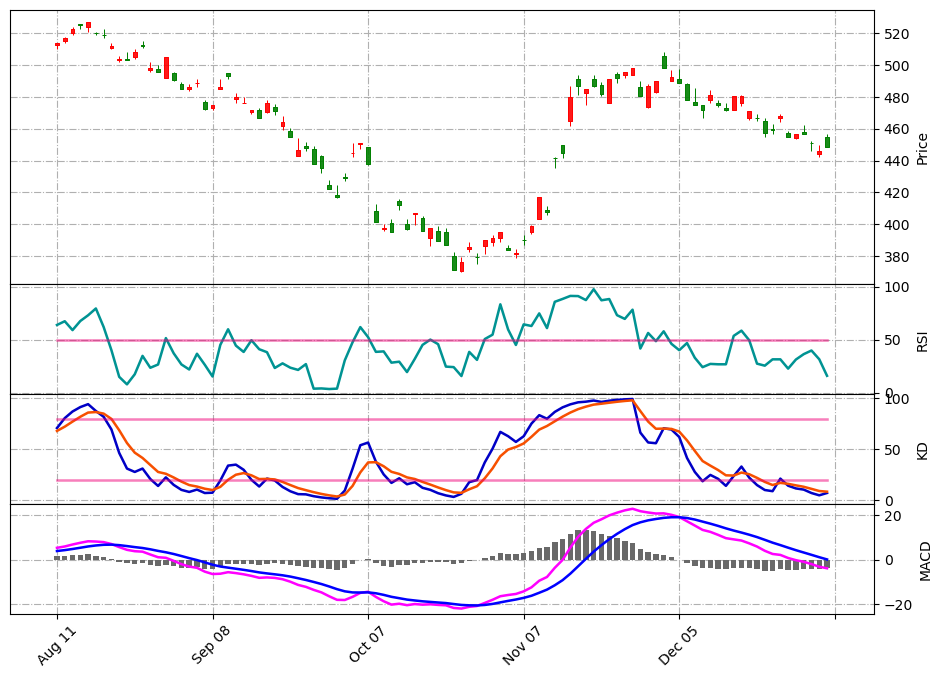

淨收益： 60163 元
投資報酬率： 61.94 %
勝率 : 100.0 %
買入持有策略_投資報酬率： 350.3 %
      日期 買/賣(+/-)     價格  價格(稅)    實際花費   目前獲利      此次投報      目前投報
0  08/23       +1   97.0   97.1  -97138 -97138       NaN  1.000000
1  03/25       -1  158.0  157.3  157301  60163  1.619356  1.619356
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
             Open   High         Low       Close   Adj Close  Volume  \
Date                                                                   
2022-12-26  101.5  101.5  100.500000  101.000000  101.000000    8716   
2022-12-27  101.0  101.5  100.500000  100.500000  100.500000    8826   
2022-12-28  100.5  100.5  100.000000  100.500000  100.500000   22673   
2022-12-29  100.0  100.0   99.500000   99.699997   99.699997   37212   
2022-12-30  100.0  100.5   99.800003   99.900002   99.900002   18093   

                  MA_5   MA_10        RSI          K          D  macd_dif  \
Dat

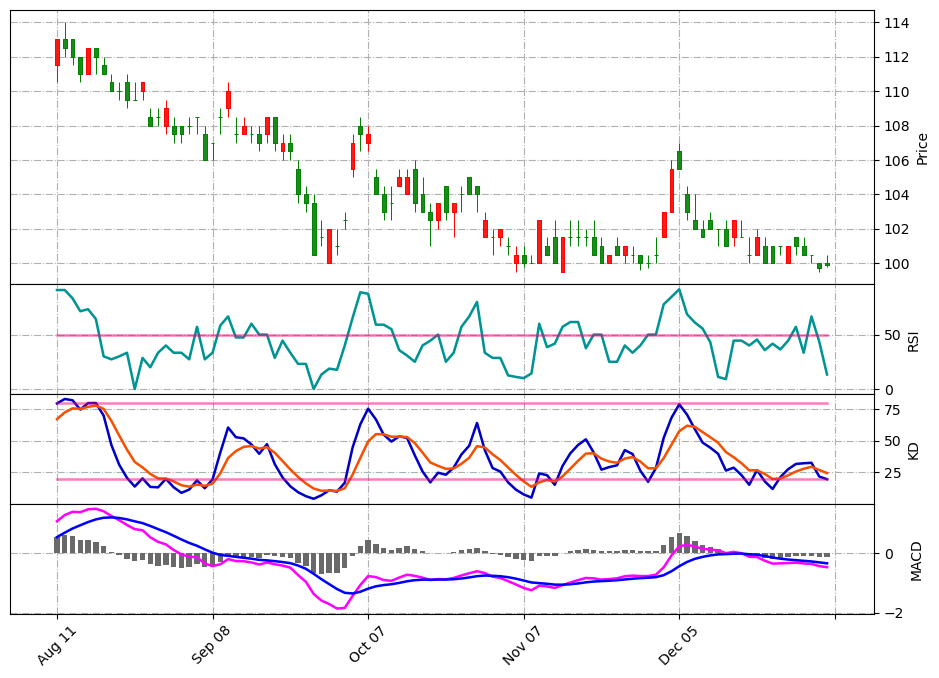

淨收益： 26254 元
投資報酬率： 35.86 %
勝率 : 100.0 %
買入持有策略_投資報酬率： 28.21 %
      日期 買/賣(+/-)         價格  價格(稅)   實際花費   目前獲利      此次投報      目前投報
0  11/28       +1  73.099998   73.2 -73204 -73204       NaN  1.000000
1  12/30       -1  99.900002   99.5  99458  26254  1.358642  1.358642
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close  Volume   MA_5   MA_10  \
Date                                                                       
2022-12-26  15.50  15.65  15.35  15.50      15.50   18548  15.13  15.235   
2022-12-27  15.60  15.70  15.45  15.50      15.50   17731  15.27  15.240   
2022-12-28  15.50  15.55  15.10  15.15      15.15   22175  15.37  15.180   
2022-12-29  15.15  15.20  15.00  15.10      15.10   25839  15.33  15.140   
2022-12-30  15.20  15.25  15.00  15.00      15.00   14923  15.25  15.135   

                  RSI          K          D

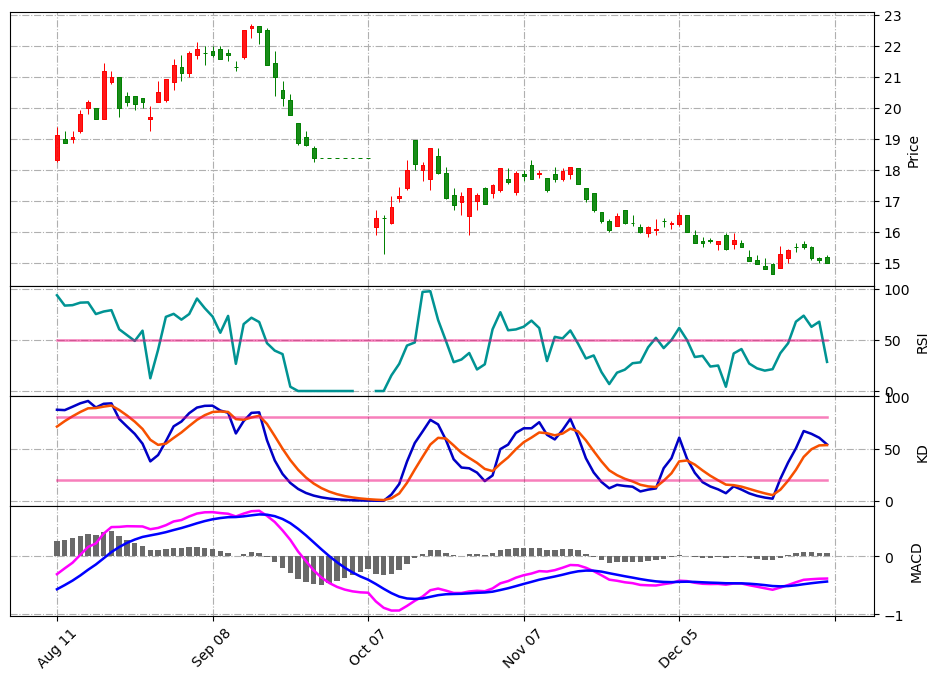

淨收益： 16861 元
投資報酬率： 26.33 %
勝率 : 100.0 %
買入持有策略_投資報酬率： -12.41 %
      日期 買/賣(+/-)       價格  價格(稅)   實際花費   目前獲利      此次投報      目前投報
0  10/22       +1  15.9375   16.0 -15960 -15960       NaN  1.000000
1  08/14       +1  12.2375   12.3 -12255 -28215       NaN  1.000000
2  08/17       +1  12.2375   12.3 -12255 -40470       NaN  1.000000
3  08/18       +1  12.1875   12.2 -12205 -52675       NaN  1.000000
4  05/23       +1  11.3375   11.4 -11354 -64029       NaN  1.000000
5  08/10       -5  16.2500   16.2  80890  16861  1.263334  1.263334
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close  Volume  \
Date                                                                        
2022-12-26  86.800003  86.900002  86.500000  86.900002  86.900002    2523   
2022-12-27  86.900002  87.199997  86.500000  87.199997  87.199997    3101   
2

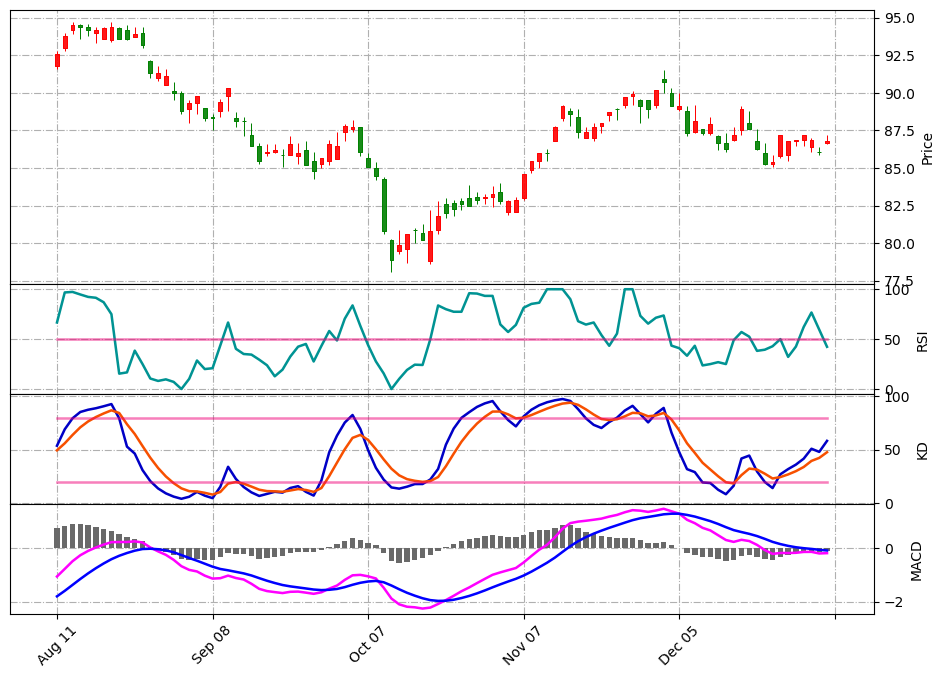

淨收益： NaN 元
投資報酬率： NaN %
勝率 : NaN %
買入持有策略_投資報酬率： 14.27 %
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close  Volume  \
Date                                                                        
2022-12-26  41.150002  41.200001  40.900002  41.000000  41.000000    9525   
2022-12-27  41.000000  41.299999  41.000000  41.150002  41.150002    8263   
2022-12-28  40.849998  41.099998  40.599998  40.650002  40.650002   15973   
2022-12-29  40.500000  40.599998  40.049999  40.099998  40.099998   17156   
2022-12-30  39.750000  40.250000  39.599998  40.000000  40.000000   99028   

                 MA_5      MA_10        RSI          K          D  macd_dif  \
Date                                                                          
2022-12-26  40.540001  40.550001  76.666573  57.548955  32.294156 -0.204656   
2022-12-27  40.

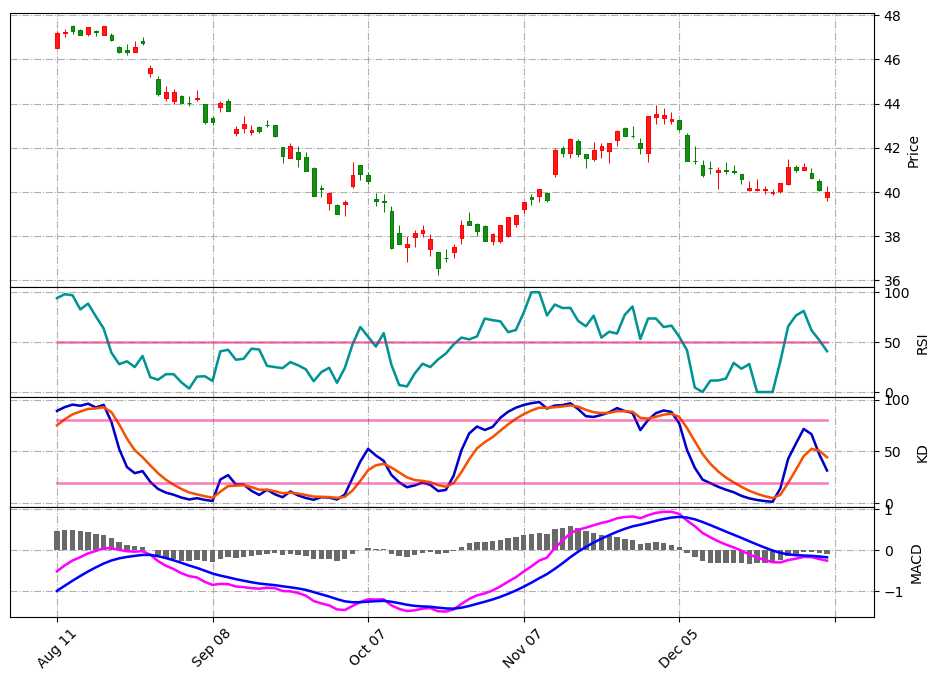

淨收益： -23035 元
投資報酬率： -26.36 %
勝率 : 0.0 %
買入持有策略_投資報酬率： 42.82 %
      日期 買/賣(+/-)         價格  價格(稅)   實際花費   目前獲利      此次投報      目前投報
0  08/28       +1  48.478405   48.5 -48547 -48547       NaN  1.000000
1  01/28       +1  43.600700   43.7 -43663 -92210       NaN  1.000000
2  06/29       -2  41.900002   41.7  83429  -8781  0.904772  0.904772
3  05/30       +1  54.000000   54.1 -54077 -62858       NaN  0.904772
4  12/30       -1  40.000000   39.8  39823 -23035  0.736413  0.666286
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close  Volume  \
Date                                                                        
2022-12-26  30.700001  30.900000  30.450001  30.600000  30.600000   18885   
2022-12-27  30.600000  30.700001  30.200001  30.299999  30.299999   20232   
2022-12-28  30.350000  30.600000  30.200001  30.600000  30

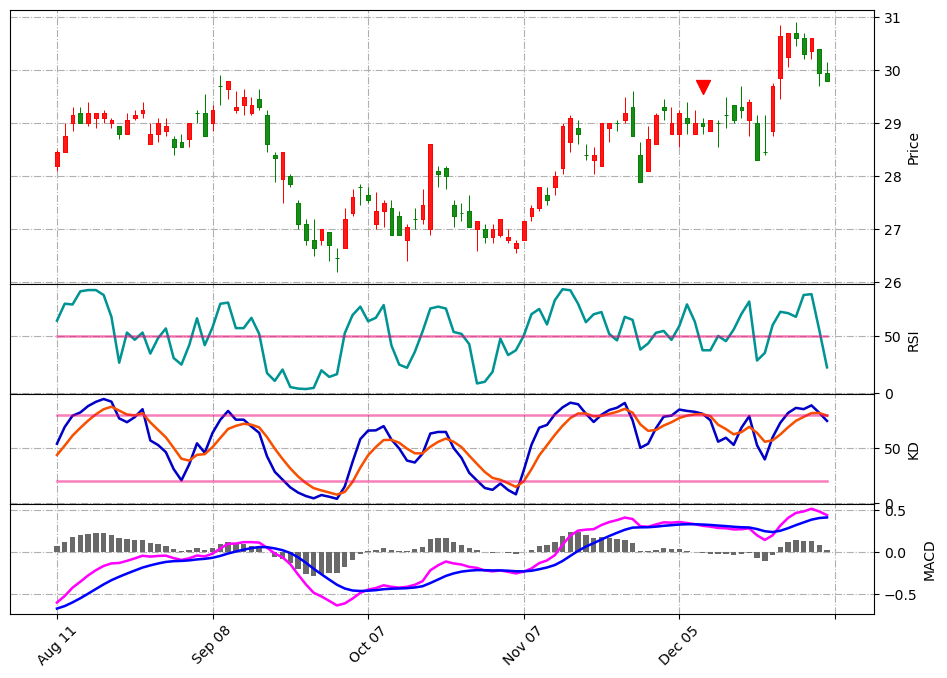

淨收益： 16199 元
投資報酬率： 0.28 %
勝率 : 100.0 %
買入持有策略_投資報酬率： 11.23 %
      日期 買/賣(+/-)         價格  價格(稅)   實際花費   目前獲利      此次投報      目前投報
0  04/22       +1  25.092215   25.1 -25128 -25128       NaN  1.000000
1  09/18       -1  25.294117   25.2  25182     54  1.002149  1.002149
2  12/17       +1  17.500000   17.5 -17525 -17471       NaN  1.002149
3  01/13       +1  17.450001   17.5 -17475 -34946       NaN  1.002149
4  05/15       +1  24.150000   24.2 -24184 -59130       NaN  1.002149
5  02/14       -3  25.200001   25.1  75265  16135  1.271712  1.274445
6  08/23       +1  23.150000   23.2 -23183  -7048       NaN  1.274445
7  11/13       -1  23.350000   23.2  23247  16199  1.002761  1.277963
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close  Volume  \
Date                                                                        
202

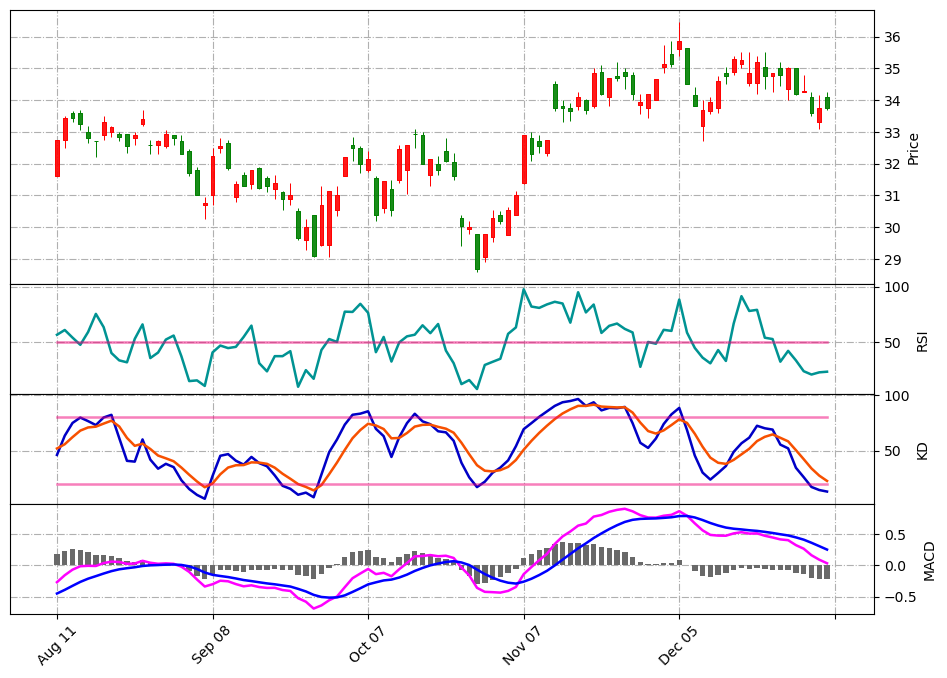

淨收益： 71353 元
投資報酬率： 73.83 %
勝率 : 100.0 %
買入持有策略_投資報酬率： 93.99 %
      日期 買/賣(+/-)         價格  價格(稅)    實際花費   目前獲利      此次投報      目前投報
0  04/22       +1   8.350328    8.4   -8362  -8362       NaN  1.000000
1  05/26       +1   6.237835    6.2   -6247 -14609       NaN  1.000000
2  08/28       +1  36.274296   36.3  -36326 -50935       NaN  1.000000
3  10/02       +1  26.500000   26.5  -26538 -77473       NaN  1.000000
4  10/23       +1  19.150000   19.2  -19177 -96650       NaN  1.000000
5  12/30       -5  33.750000   33.6  168003  71353  1.738262  1.738262
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close  Volume   MA_5   MA_10  \
Date                                                                       
2022-12-26  281.5  283.5  279.5  282.0      282.0    1897  283.2  287.95   
2022-12-27  283.0  286.0  282.0  284.0      284.0    1516  28

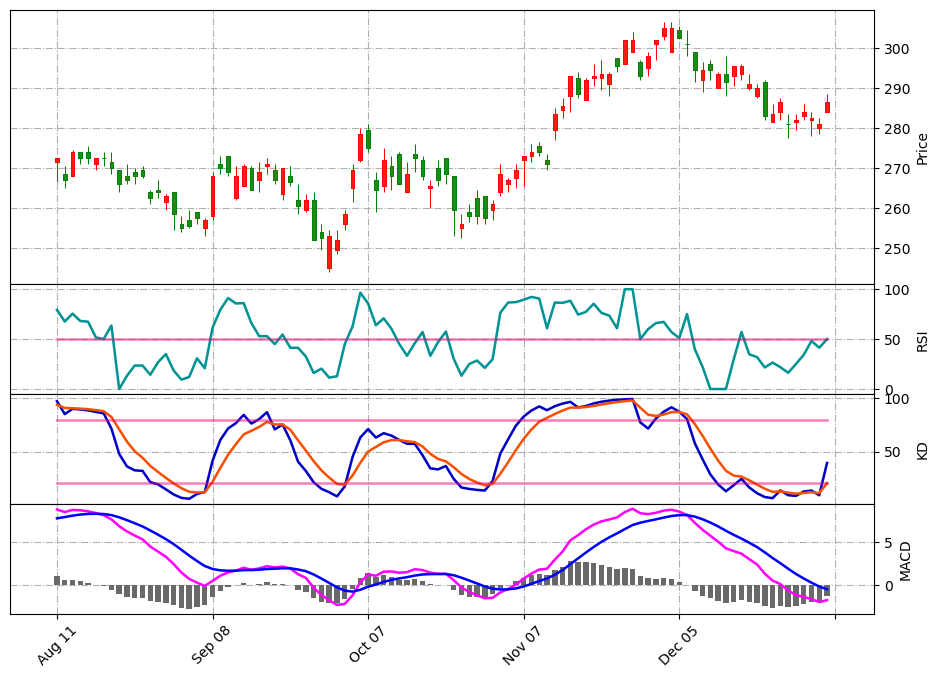

淨收益： 22621 元
投資報酬率： 9.36 %
勝率 : 100.0 %
買入持有策略_投資報酬率： 167.31 %
      日期 買/賣(+/-)          價格  價格(稅)    實際花費    目前獲利      此次投報      目前投報
0  07/15       +1  157.530563  157.8 -157755 -157755       NaN  1.000000
1  07/26       -1  168.000000  167.3  167257    9502  1.060233  1.060233
2  11/22       +1  140.000000  140.2 -140200 -130698       NaN  1.060233
3  02/22       -1  154.000000  153.3  153319   22621  1.093573  1.159442
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close  Volume  \
Date                                                                        
2022-12-26  23.100000  23.299999  23.100000  23.250000  23.250000    2803   
2022-12-27  23.250000  23.400000  23.150000  23.299999  23.299999    3336   
2022-12-28  23.150000  23.400000  23.100000  23.299999  23.299999    4427   
2022-12-29  23.200001  23.600000  23

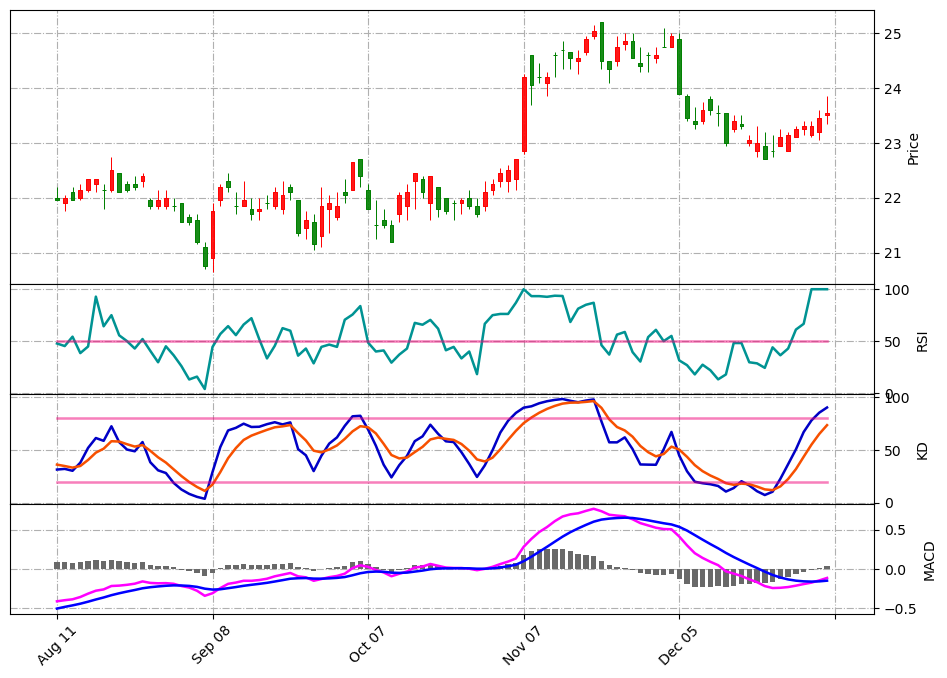

淨收益： NaN 元
投資報酬率： NaN %
勝率 : NaN %
買入持有策略_投資報酬率： -4.99 %
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
             Open   High   Low  Close  Adj Close  Volume   MA_5  MA_10  \
Date                                                                     
2022-12-26   9.90  10.15  9.90  10.00      10.00    7743  9.854  9.938   
2022-12-27  10.10  10.10  9.99  10.00      10.00    4488  9.908  9.938   
2022-12-28  10.00  10.05  9.90   9.90       9.90    4473  9.944  9.923   
2022-12-29   9.85   9.91  9.83   9.87       9.87    3448  9.926  9.900   
2022-12-30   9.93   9.95  9.86   9.88       9.88    3312  9.930  9.888   

                  RSI          K          D  macd_dif  macd_dem  macd_bar  
Date                                                                       
2022-12-26  50.000000  43.933727  28.896110  0.011443  0.042956 -0.031514  
2022-12-27  52.777774  53.850524  37.214248  

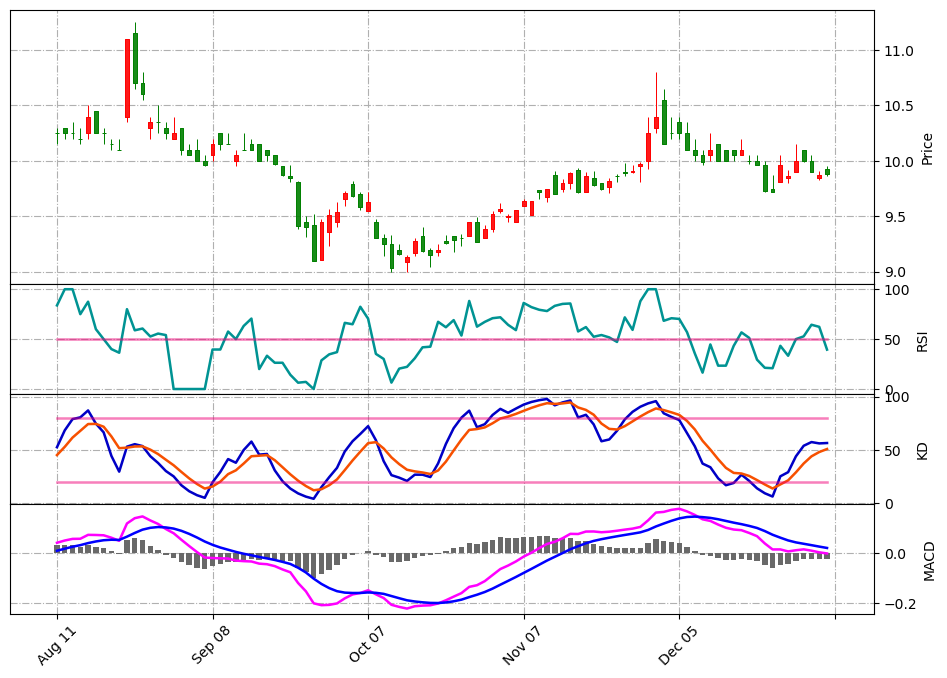

淨收益： 2700 元
投資報酬率： 10.07 %
勝率 : 100.0 %
買入持有策略_投資報酬率： -42.53 %
      日期 買/賣(+/-)         價格  價格(稅)   實際花費   目前獲利      此次投報      目前投報
0  05/27       +1  10.523809   10.5 -10539 -10539       NaN  1.000000
1  11/20       +1   8.780952    8.8  -8793 -19332       NaN  1.000000
2  12/16       +1   7.466666    7.5  -7477 -26809       NaN  1.000000
3  12/30       -3   9.880000    9.8  29509   2700  1.100712  1.100712
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close  Volume  \
Date                                                                        
2022-12-26  65.800003  66.000000  65.699997  65.800003  65.800003    1546   
2022-12-27  66.000000  66.300003  65.900002  66.199997  66.199997    3748   
2022-12-28  65.800003  66.199997  65.599998  66.199997  66.199997    5295   
2022-12-29  65.699997  66.400002  65.699997  66.300

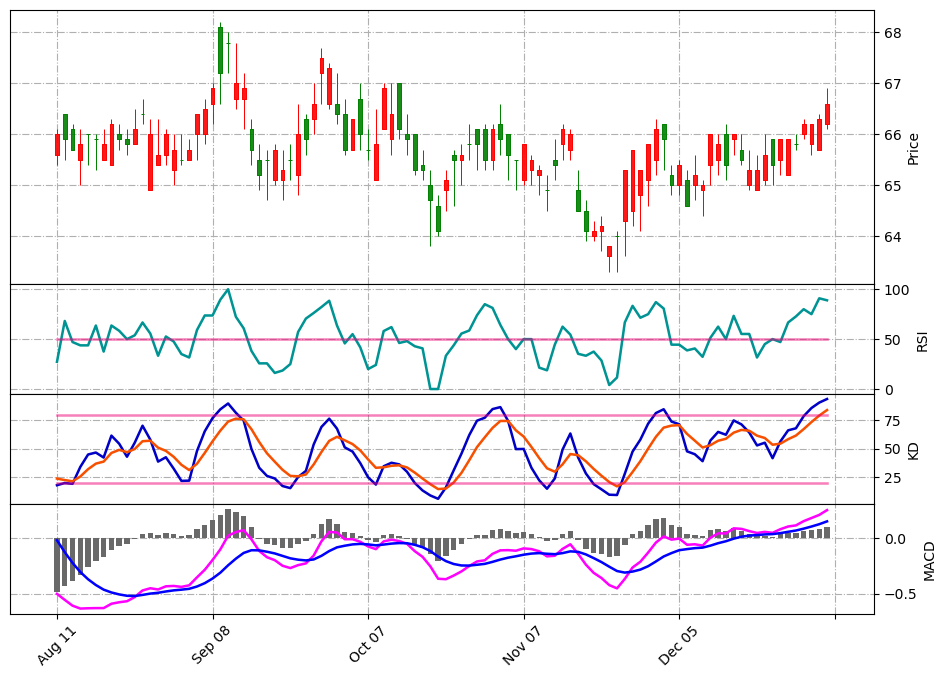

淨收益： 11524 元
投資報酬率： 20.81 %
勝率 : 100.0 %
買入持有策略_投資報酬率： 44.39 %
      日期 買/賣(+/-)         價格  價格(稅)   實際花費   目前獲利      此次投報      目前投報
0  12/08       +1  55.299999   55.4 -55379 -55379       NaN  1.000000
1  02/26       -1  67.199997   66.9  66903  11524  1.208093  1.208093
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close  Volume  \
Date                                                                        
2022-12-26  69.900002  70.500000  69.800003  70.500000  70.500000    1122   
2022-12-27  70.900002  71.199997  70.599998  70.800003  70.800003    1238   
2022-12-28  70.000000  70.800003  69.500000  70.000000  70.000000    1178   
2022-12-29  69.599998  69.900002  69.300003  69.800003  69.800003    2190   
2022-12-30  70.199997  70.699997  70.099998  70.500000  70.500000    1029   

                 MA_5      MA_10    

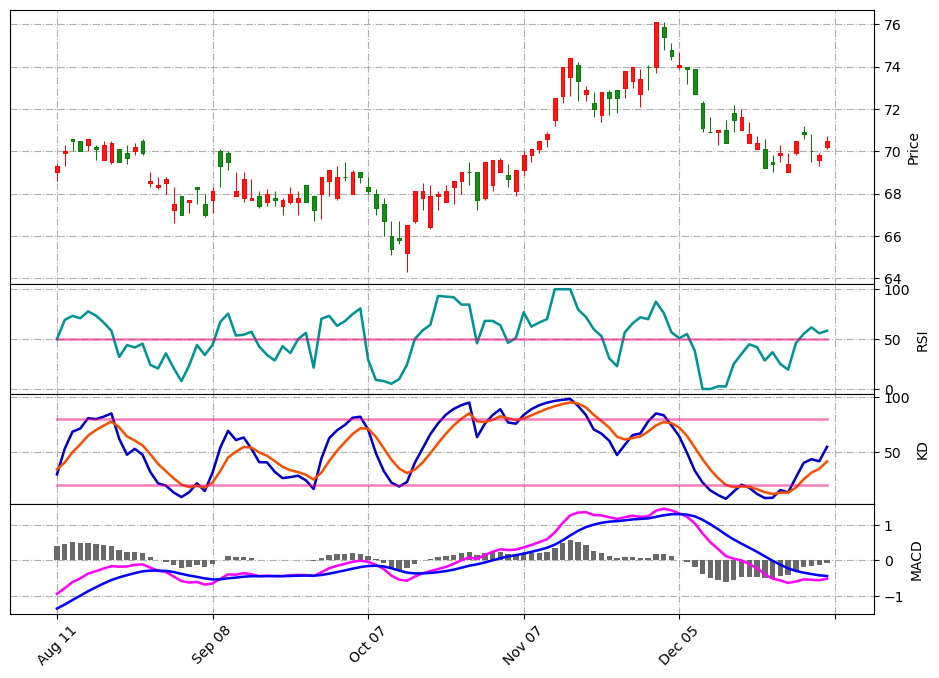

淨收益： 1755 元
投資報酬率： -19.35 %
勝率 : 50.0 %
買入持有策略_投資報酬率： -3.69 %
      日期 買/賣(+/-)         價格  價格(稅)   實際花費   目前獲利      此次投報      目前投報
0  04/17       +1  65.242722   65.3 -65336 -65336       NaN  1.000000
1  08/17       -1  84.300003   83.9  83927  18591  1.284545  1.284545
2  08/21       +1  86.900002   87.0 -87024 -68433       NaN  1.284545
3  12/30       -1  70.500000   70.2  70188   1755  0.806536  1.036032
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close  Volume  \
Date                                                                        
2022-12-26  34.349998  34.450001  34.099998  34.400002  34.400002   12280   
2022-12-27  34.549999  34.700001  34.299999  34.299999  34.299999   11350   
2022-12-28  34.150002  34.349998  33.950001  34.299999  34.299999   13791   
2022-12-29  34.250000  34.250000  33.700001  33.7000

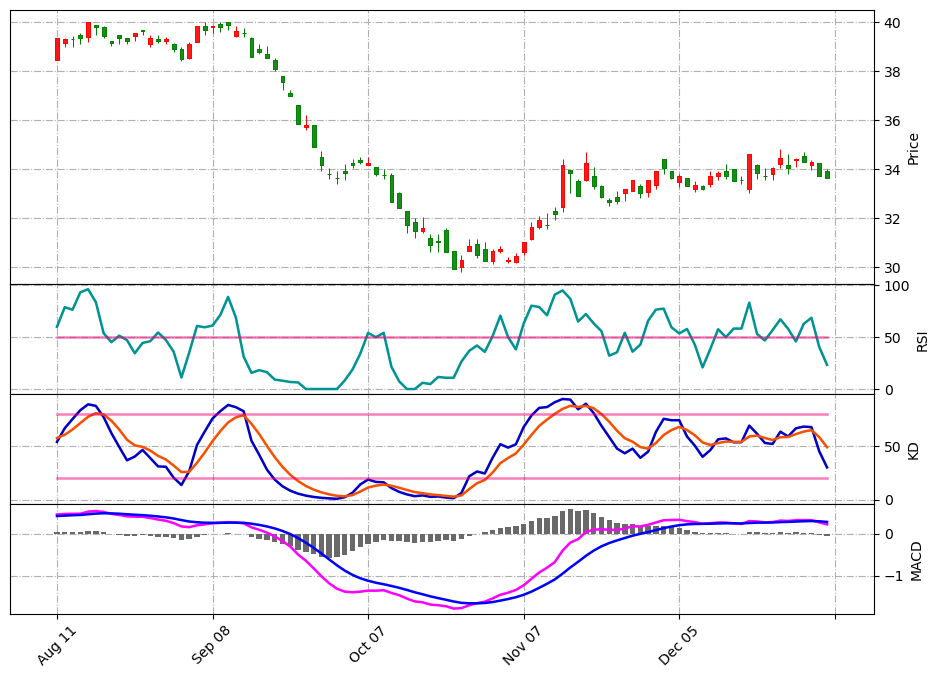

淨收益： -4898 元
投資報酬率： -24.83 %
勝率 : 33.33333333333333 %
買入持有策略_投資報酬率： 17.3 %
      日期 買/賣(+/-)         價格  價格(稅)   實際花費   目前獲利      此次投報      目前投報
0  06/23       +1  28.355898   28.4 -28396 -28396       NaN  1.000000
1  07/22       -1  25.634319   25.5  25521  -2875  0.898753  0.898753
2  11/02       +1  24.714869   24.8 -24750 -27625       NaN  0.898753
3  04/17       -1  33.942486   33.8  33792   6167  1.365333  1.227098
4  11/08       +1  44.502903   44.6 -44566 -38399       NaN  1.227098
5  12/30       -1  33.650002   33.5  33501  -4898  0.751717  0.922430
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close  Volume  \
Date                                                                        
2022-12-26  35.000000  35.000000  34.150002  34.200001  34.200001    7979   
2022-12-27  34.250000  34.799999  34.250000  34.29999

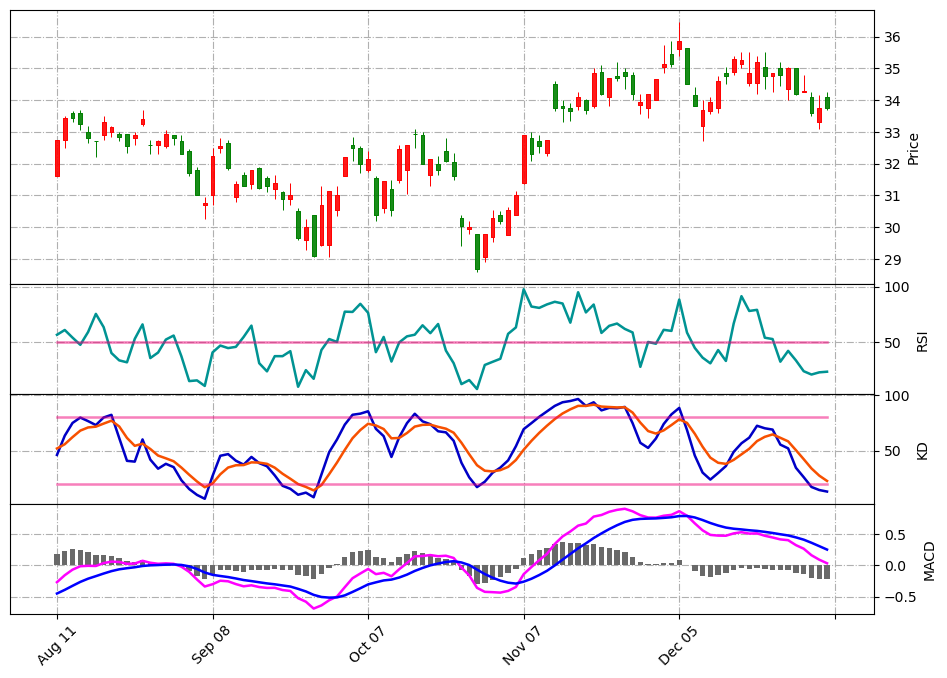

淨收益： 71353 元
投資報酬率： 73.83 %
勝率 : 100.0 %
買入持有策略_投資報酬率： 93.99 %
      日期 買/賣(+/-)         價格  價格(稅)    實際花費   目前獲利      此次投報      目前投報
0  04/22       +1   8.350328    8.4   -8362  -8362       NaN  1.000000
1  05/26       +1   6.237835    6.2   -6247 -14609       NaN  1.000000
2  08/28       +1  36.274296   36.3  -36326 -50935       NaN  1.000000
3  10/02       +1  26.500000   26.5  -26538 -77473       NaN  1.000000
4  10/23       +1  19.150000   19.2  -19177 -96650       NaN  1.000000
5  12/30       -5  33.750000   33.6  168003  71353  1.738262  1.738262
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close  Volume  \
Date                                                                        
2022-12-26  49.400002  49.599998  49.200001  49.450001  49.450001     388   
2022-12-27  49.450001  49.549999  49.250000  49.450001  49

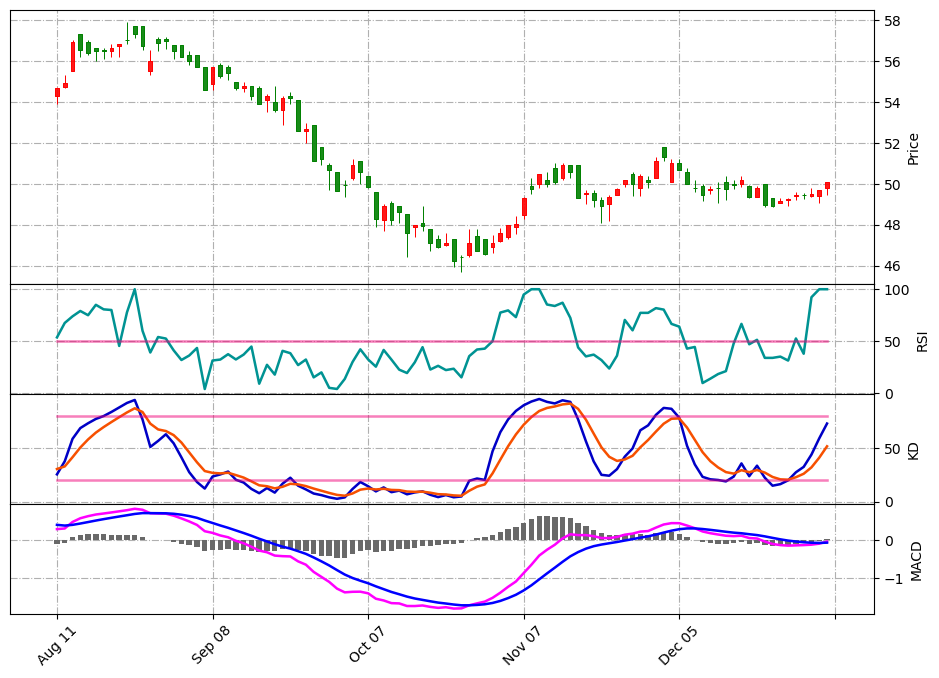

淨收益： 322 元
投資報酬率： 2.82 %
勝率 : 100.0 %
買入持有策略_投資報酬率： 355.52 %
      日期 買/賣(+/-)         價格  價格(稅)   實際花費   目前獲利      此次投報      目前投報
0  09/30       +1  11.408235   11.4 -11424 -11424       NaN  1.000000
1  03/18       -1  11.798517   11.7  11746    322  1.028186  1.028186
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-12-26  110.800003  111.199997  110.699997  111.099998  111.099998   
2022-12-27  111.400002  112.250000  111.400002  111.599998  111.599998   
2022-12-28  110.500000  110.500000  109.400002  110.000000  110.000000   
2022-12-29  109.199997  109.599998  108.400002  109.500000  109.500000   
2022-12-30  110.599998  110.750000  110.199997  110.199997  110.199997   

            Volume        MA_5       MA_10        RSI      

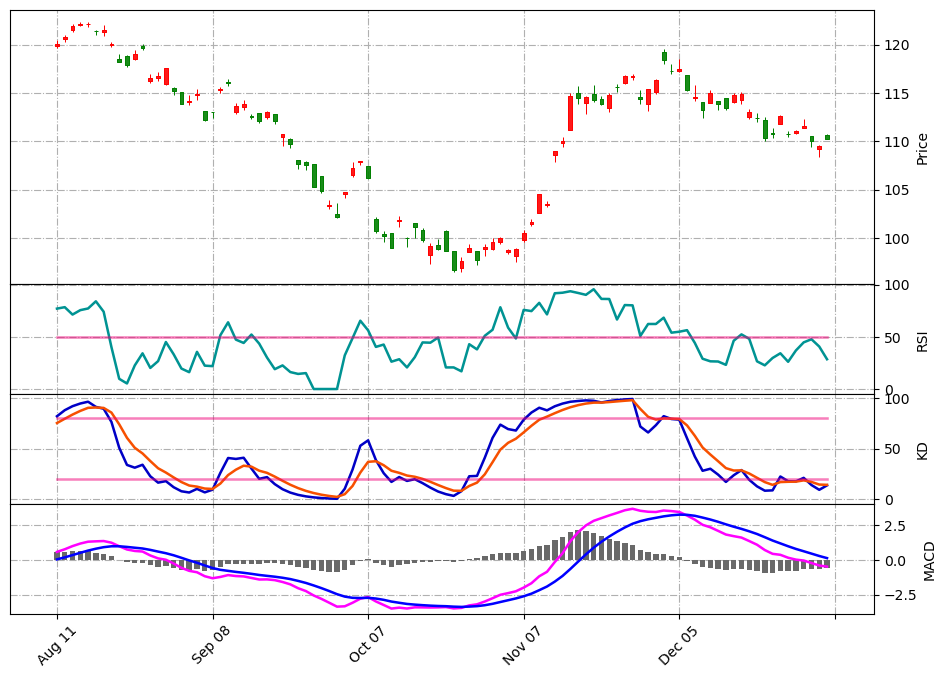

淨收益： NaN 元
投資報酬率： NaN %
勝率 : NaN %
買入持有策略_投資報酬率： 102.57 %
---------------------------------------------------------------------------------


code return rate accuracy Buy&Hold return rate
0   2330.TW     61.94 %  100.0 %              350.3 %
1   2317.TW     35.86 %  100.0 %              28.21 %
2   2409.TW     26.33 %  100.0 %             -12.41 %
3   1301.TW       NaN %    NaN %              14.27 %
4   2882.TW    -26.36 %    0.0 %              42.82 %
5   2002.TW      0.28 %  100.0 %              11.23 %
6   2337.TW     73.83 %  100.0 %              93.99 %
7   2308.TW      9.36 %  100.0 %             167.31 %
8   2353.TW       NaN %    NaN %              -4.99 %
9   1314.TW     10.07 %  100.0 %             -42.53 %
10  1216.TW     20.81 %  100.0 %              44.39 %
11  1326.TW    -19.35 %   50.0 %              -3.69 %
12  1101.TW    -24.83 %  33.33 %               17.3 %
13  2337.TW     73.83 %  100.0 %              93.99 %
14  1229.TW      2.82 %  100.0 %             355.52 %
15  0050.TW       NaN %    NaN %             102.57 %

In [71]:
df = 完整版實作(ticks,start='2013-01-01',end='2023-01-01',period='max' ,interval='1d',excel_path = excel_path)
df

註解：NaN表示該標的策略交易上沒有產生任何的交易訊號

## 總結 - 日資料

In [68]:
df_total = df_add(df)
df_total

name     code return rate accuracy Buy&Hold return rate industries
0      台積電  2330.TW     61.94 %  100.0 %              350.3 %       半導體業
1       鴻海  2317.TW     35.86 %  100.0 %              28.21 %        電子業
2      宏達電  2409.TW     26.33 %  100.0 %             -12.41 %      通信網路業
3       台塑  1301.TW       NaN %    NaN %              14.27 %       塑膠工業
4      國泰金  2882.TW    -26.36 %    0.0 %              42.82 %      金融保險業
5       中鋼  2002.TW      0.28 %  100.0 %              11.23 %       鋼鐵工業
6     奇美電子  2337.TW     73.83 %  100.0 %              93.99 %        光電業
7      台達電  2308.TW      9.36 %  100.0 %             167.31 %     電子零組件業
8       宏碁  2353.TW       NaN %    NaN %              -4.99 %   電腦及週邊設備業
9     台塑石化  1314.TW     10.07 %  100.0 %             -42.53 %      油電燃氣業
10      統一  1216.TW     20.81 %  100.0 %              44.39 %       食品工業
11     遠東新  1326.TW    -19.35 %   50.0 %              -3.69 %       紡織纖維
12      台泥  1101.TW    -24.83 %  33.33 %               17.3 %       水泥工業
13    聯強國際  2337.TW     73.83 %  100.0 %              93.99 %      電子通路業
14     統一超  1229.TW      2.82 %  100.0 %             355.52 %       貿易百貨
15  台灣50指數  0050.TW       NaN %    NaN %             102.57 %        ETF

In [72]:
#寫入excel檔案
df_to_excel(df_total, excel_path = excel_path, sheet_name = '統整2(Overview)', startcol=0)

## 測試高頻資料
* yfinance 套件最多只能抓到**最近60天**的分鐘資料！因此抓分鐘資料時period參數**"最多"**只能設定為'60d'，否則會報錯

[*********************100%***********************]  1 of 1 completed
                      Open   High    Low  Close  Adj Close  Volume   MA_5  \
Datetime                                                                    
2023-01-06 11:30:00  458.5  459.0  458.5  459.0      459.0     757  457.1   
2023-01-06 12:00:00  458.5  459.5  458.0  458.0      458.0    2279  457.4   
2023-01-06 12:30:00  458.5  458.5  457.5  457.5      457.5    1082  457.9   
2023-01-06 13:00:00  458.0  458.0  457.0  457.0      457.0    1512  458.0   
2023-01-06 13:30:00  458.5  458.5  458.5  458.5      458.5       0  458.0   

                      MA_10        RSI          K          D  macd_dif  \
Datetime                                                                 
2023-01-06 11:30:00  457.20  62.500000  73.561402  61.551746  1.466656   
2023-01-06 12:00:00  457.35  50.000000  74.040935  65.714809  1.442757   
2023-01-06 12:30:00  457.35  57.142857  70.193956  67.207858  1.367706   
2023-01-06 13:00:00  

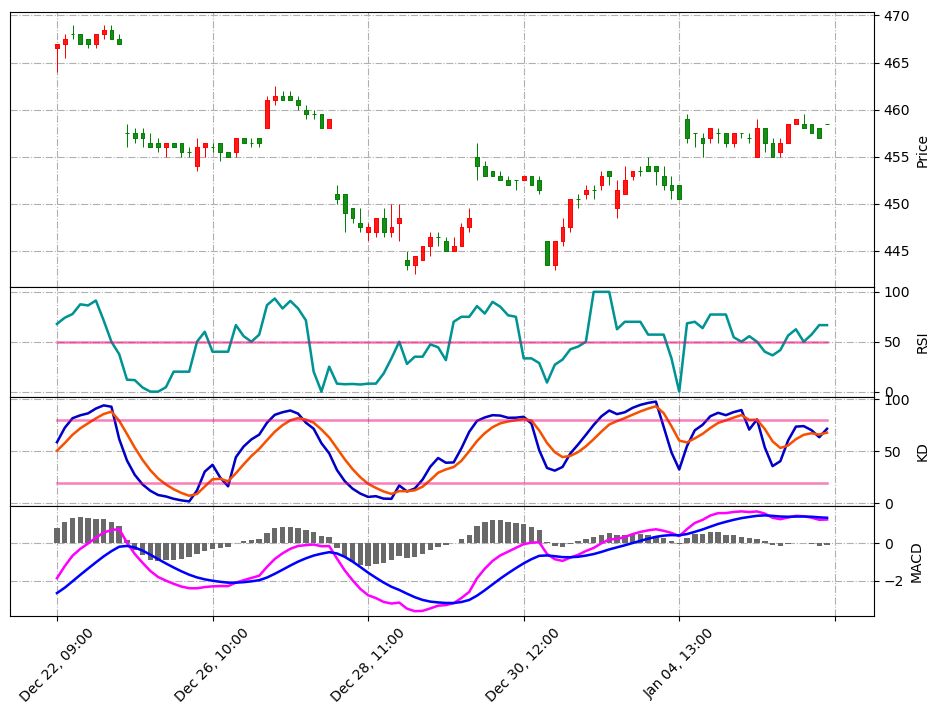

淨收益： NaN 元
投資報酬率： NaN %
勝率 : NaN %
買入持有策略_投資報酬率： 11.83 %
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
                          Open       High        Low      Close  Adj Close  \
Datetime                                                                     
2023-01-06 11:30:00  98.800003  98.800003  98.599998  98.599998  98.599998   
2023-01-06 12:00:00  98.699997  98.800003  98.599998  98.599998  98.599998   
2023-01-06 12:30:00  98.599998  98.800003  98.599998  98.599998  98.599998   
2023-01-06 13:00:00  98.599998  98.699997  98.500000  98.599998  98.599998   
2023-01-06 13:30:00  98.400002  98.400002  98.400002  98.400002  98.400002   

                     Volume       MA_5      MA_10        RSI          K  \
Datetime                                                                  
2023-01-06 11:30:00     993  98.579999  98.389999  77.777966  84.030216   
2023-01-06 12:00:00 

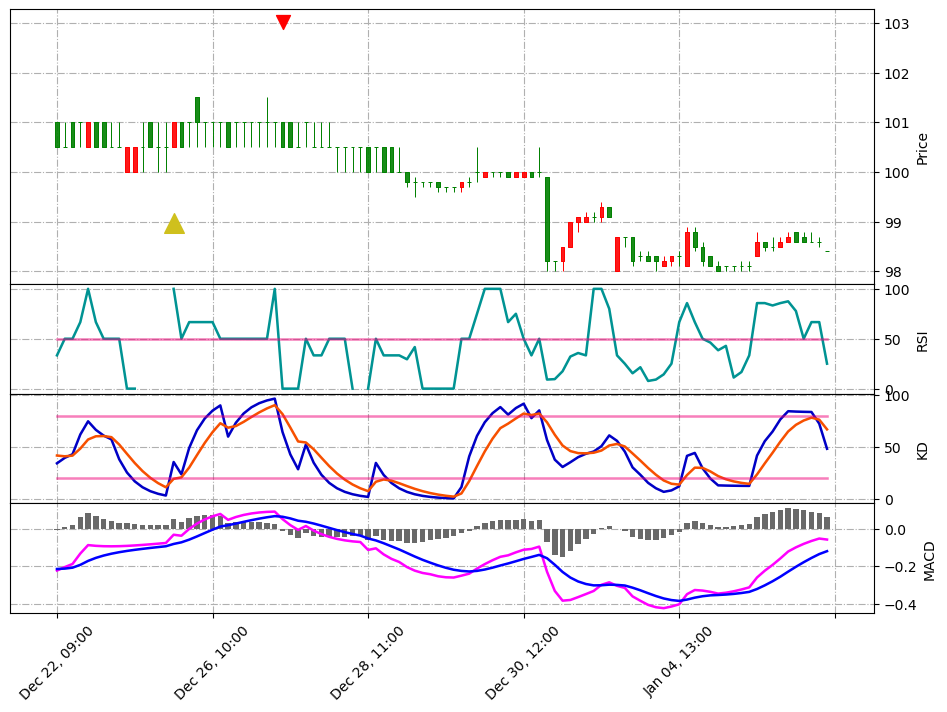

淨收益： -2264 元
投資報酬率： -0.75 %
勝率 : 0.0 %
買入持有策略_投資報酬率： -5.84 %
      日期 買/賣(+/-)     價格  價格(稅)    實際花費    目前獲利      此次投報      目前投報
0  11/04       +1  100.5  100.6 -100643 -100643       NaN  1.000000
1  11/07       +1  100.5  100.6 -100643 -201286       NaN  1.000000
2  12/23       +1  101.0  101.1 -101144 -302430       NaN  1.000000
3  12/27       -3  100.5  100.1  300166   -2264  0.992514  0.992514
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
                      Open       High    Low  Close  Adj Close  Volume   MA_5  \
Datetime                                                                        
2023-01-06 11:30:00  16.00  16.049999  15.95  16.00      16.00    3082  15.90   
2023-01-06 12:00:00  15.95  16.000000  15.95  16.00      16.00    1969  15.94   
2023-01-06 12:30:00  16.00  16.000000  15.90  15.90      15.90    2921  15.96   
2023-01-06 13:00:00  15.90  16.000000  15.9

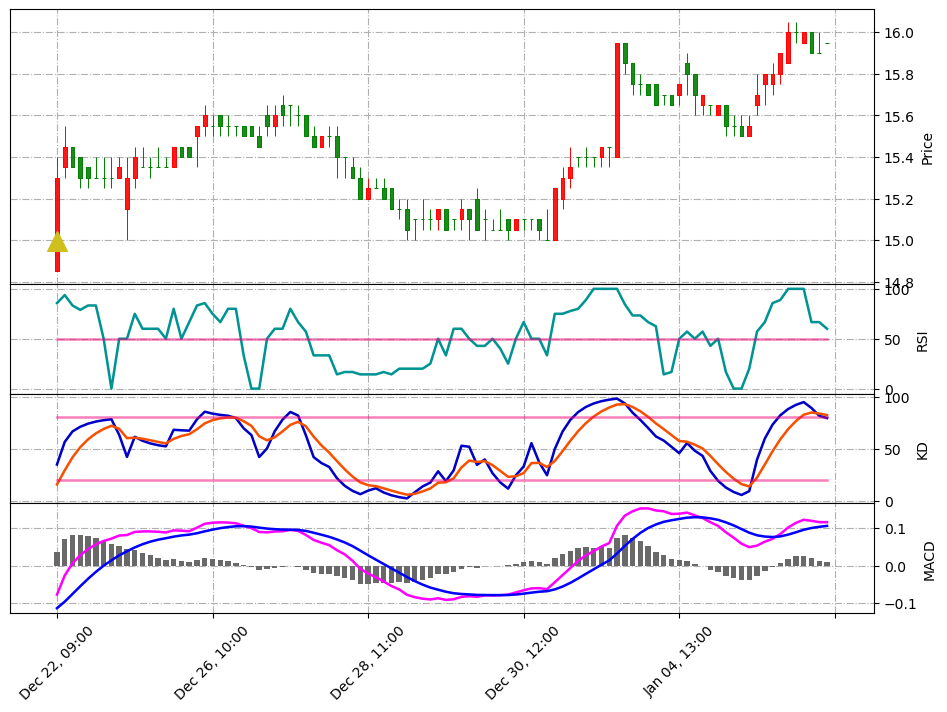

淨收益： -87 元
投資報酬率： -0.27 %
勝率 : 0.0 %
買入持有策略_投資報酬率： -6.73 %
      日期 買/賣(+/-)     價格  價格(稅)   實際花費   目前獲利      此次投報      目前投報
0  11/23       +1  16.50   16.5 -16524 -16524       NaN  1.000000
1  12/22       +1  15.30   15.3 -15322 -31846       NaN  1.000000
2  01/06       -2  15.95   15.9  31759    -87  0.997268  0.997268
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
                          Open       High        Low      Close  Adj Close  \
Datetime                                                                     
2023-01-06 11:30:00  88.000000  88.000000  87.699997  87.800003  87.800003   
2023-01-06 12:00:00  87.699997  87.900002  87.699997  87.800003  87.800003   
2023-01-06 12:30:00  87.699997  87.800003  87.599998  87.699997  87.699997   
2023-01-06 13:00:00  87.599998  87.900002  87.599998  87.800003  87.800003   
2023-01-06 13:30:00  88.000000  88.000000  88.000000  88.0

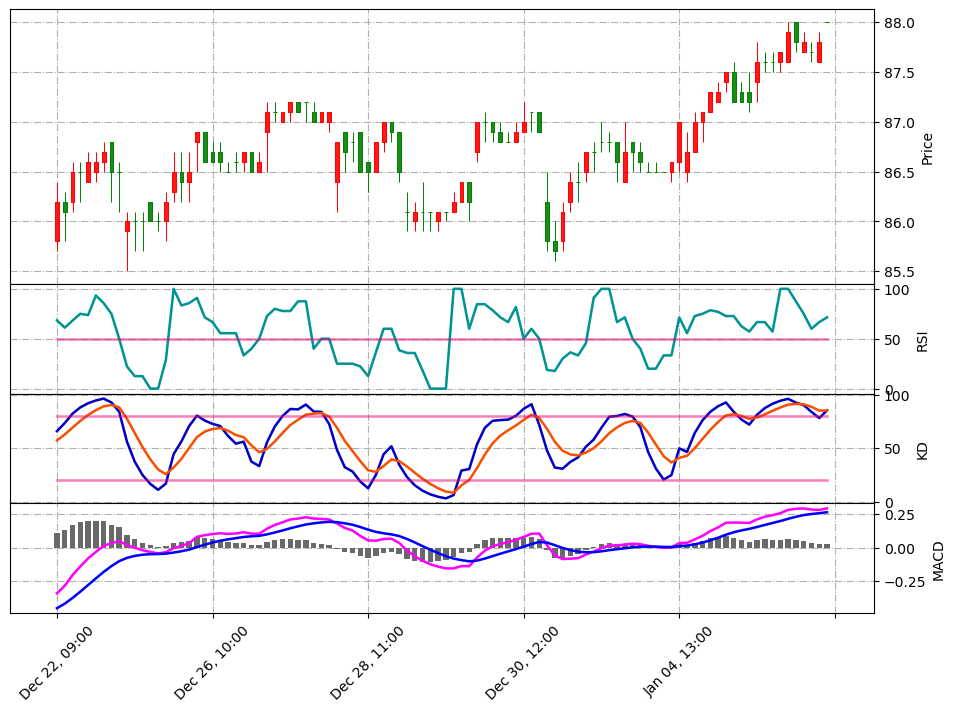

淨收益： NaN 元
投資報酬率： NaN %
勝率 : NaN %
買入持有策略_投資報酬率： 10.28 %
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
                          Open       High        Low      Close  Adj Close  \
Datetime                                                                     
2023-01-06 11:30:00  40.500000  40.650002  40.500000  40.549999  40.549999   
2023-01-06 12:00:00  40.549999  40.700001  40.549999  40.650002  40.650002   
2023-01-06 12:30:00  40.700001  40.700001  40.599998  40.650002  40.650002   
2023-01-06 13:00:00  40.700001  40.799999  40.650002  40.750000  40.750000   
2023-01-06 13:30:00  40.750000  40.750000  40.750000  40.750000  40.750000   

                     Volume       MA_5   MA_10    RSI          K          D  \
Datetime                                                                      
2023-01-06 11:30:00    3613  40.389999  40.270  100.0  96.644402  89.943580   
2023-01-

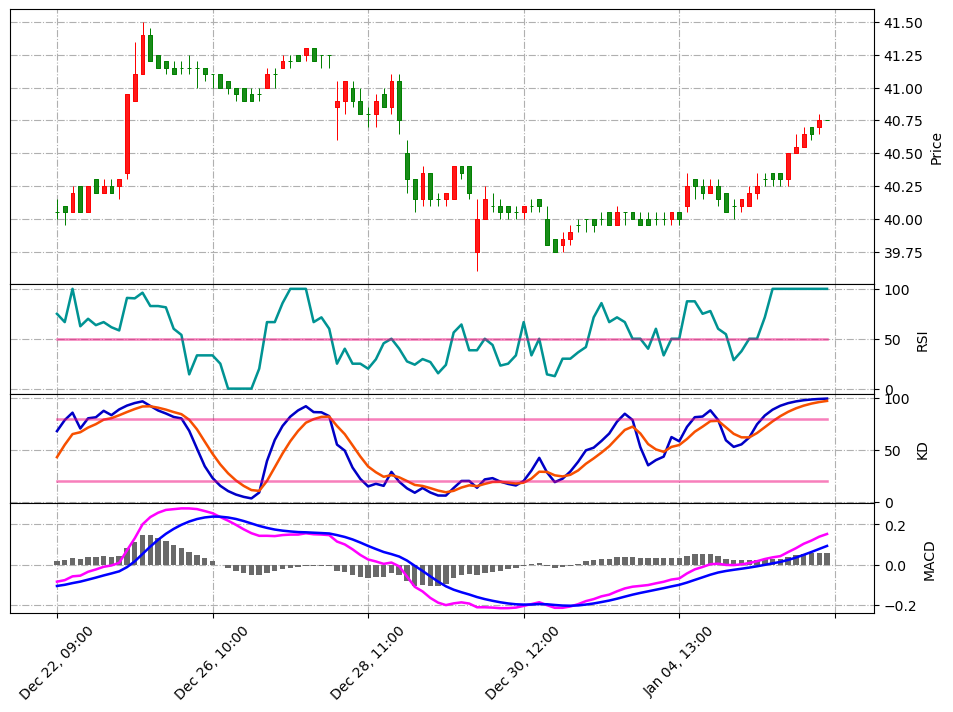

淨收益： -427 元
投資報酬率： -0.52 %
勝率 : 0.0 %
買入持有策略_投資報酬率： 7.1 %
      日期 買/賣(+/-)         價格  價格(稅)   實際花費   目前獲利      此次投報      目前投報
0  12/09       +1  41.400002   41.5 -41459 -41459       NaN  1.000000
1  12/21       +1  40.049999   40.1 -40107 -81566       NaN  1.000000
2  01/06       -2  40.750000   40.6  81139   -427  0.994765  0.994765
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
                      Open   High        Low      Close  Adj Close  Volume  \
Datetime                                                                     
2023-01-06 11:30:00  30.10  30.10  30.049999  30.049999  30.049999    1350   
2023-01-06 12:00:00  30.10  30.15  30.049999  30.150000  30.150000    1187   
2023-01-06 12:30:00  30.15  30.15  30.049999  30.100000  30.100000    1529   
2023-01-06 13:00:00  30.10  30.10  30.049999  30.049999  30.049999     872   
2023-01-06 13:30:00  30.15  30.15  30.15000

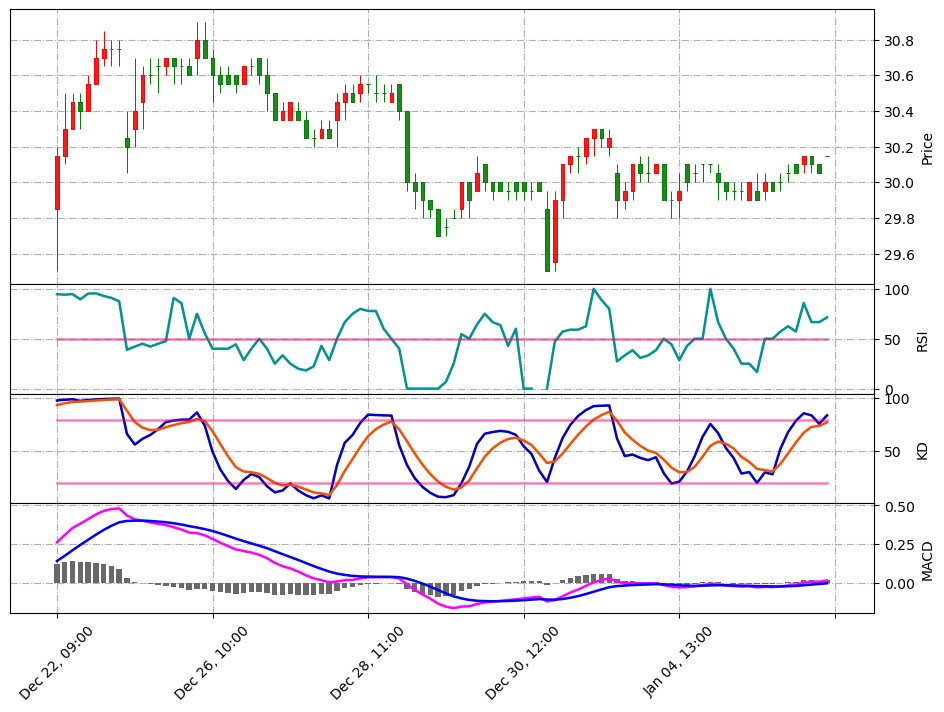

淨收益： NaN 元
投資報酬率： NaN %
勝率 : NaN %
買入持有策略_投資報酬率： 11.25 %
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
                          Open       High        Low      Close  Adj Close  \
Datetime                                                                     
2023-01-06 11:30:00  34.700001  34.700001  34.599998  34.599998  34.599998   
2023-01-06 12:00:00  34.599998  34.650002  34.549999  34.549999  34.549999   
2023-01-06 12:30:00  34.549999  34.750000  34.549999  34.700001  34.700001   
2023-01-06 13:00:00  34.700001  34.750000  34.650002  34.750000  34.750000   
2023-01-06 13:30:00  34.750000  34.750000  34.750000  34.750000  34.750000   

                     Volume   MA_5   MA_10        RSI          K          D  \
Datetime                                                                      
2023-01-06 11:30:00     128  34.56  34.435  78.571234  85.187115  76.319905   
2023-01-

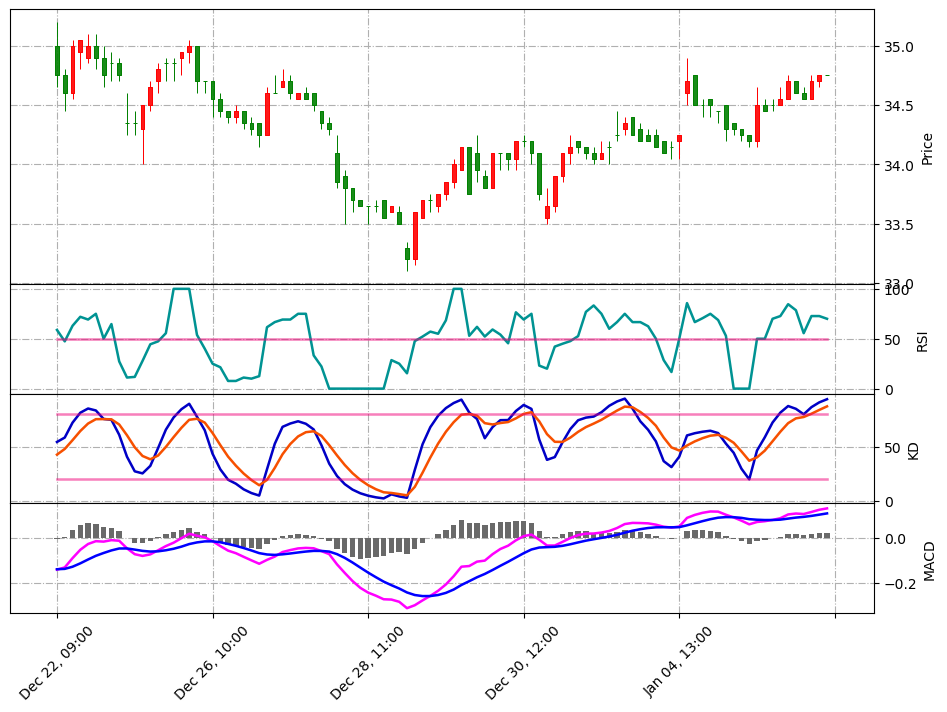

淨收益： 5953 元
投資報酬率： 20.46 %
勝率 : 100.0 %
買入持有策略_投資報酬率： 10.14 %
      日期 買/賣(+/-)         價格  價格(稅)   實際花費   目前獲利      此次投報      目前投報
0  10/31       +1  29.049999   29.1 -29091 -29091       NaN  1.000000
1  12/15       -1  35.200001   35.0  35044   5953  1.204634  1.204634
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
                      Open   High    Low  Close  Adj Close  Volume   MA_5  \
Datetime                                                                    
2023-01-06 11:30:00  274.5  274.5  273.0  273.0      273.0     555  273.9   
2023-01-06 12:00:00  273.0  273.5  273.0  273.0      273.0     546  273.6   
2023-01-06 12:30:00  273.5  273.5  271.5  272.5      272.5    1517  273.2   
2023-01-06 13:00:00  273.0  273.0  271.5  272.5      272.5    1028  273.0   
2023-01-06 13:30:00  272.0  272.0  272.0  272.0      272.0       0  272.6   

                      MA_10        RS

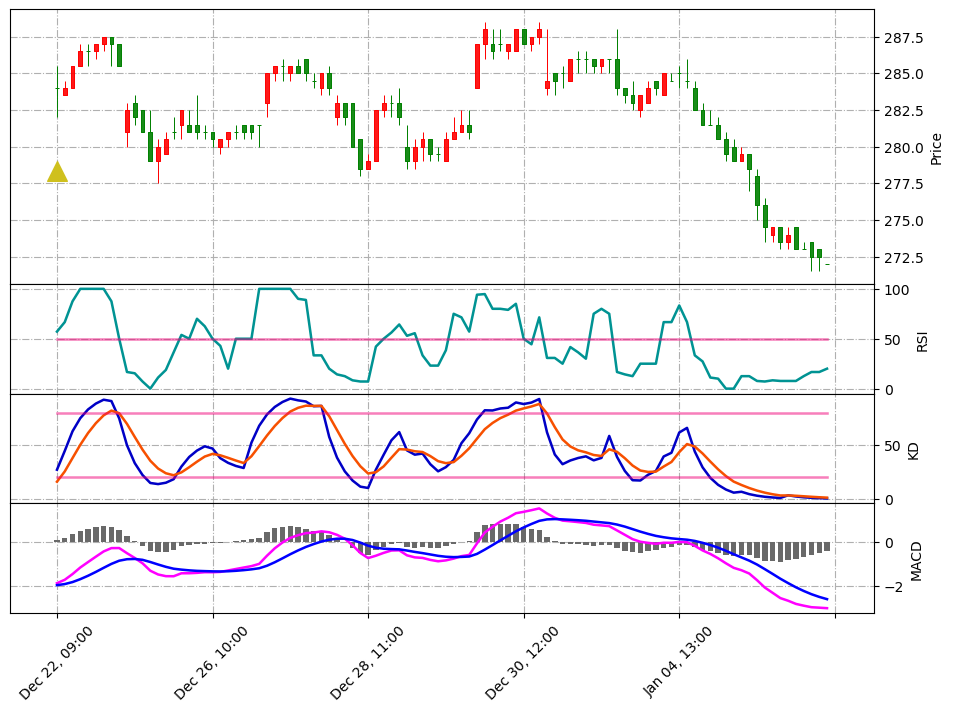

淨收益： -13609 元
投資報酬率： -4.79 %
勝率 : 0.0 %
買入持有策略_投資報酬率： 0.74 %
      日期 買/賣(+/-)     價格  價格(稅)    實際花費    目前獲利      此次投報      目前投報
0  12/22       +1  284.0  284.4 -284405 -284405       NaN  1.000000
1  01/06       -1  272.0  270.8  270796  -13609  0.952149  0.952149
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
                          Open       High   Low      Close  Adj Close  Volume  \
Datetime                                                                        
2023-01-06 11:30:00  24.049999  24.100000  24.0  24.049999  24.049999     659   
2023-01-06 12:00:00  24.049999  24.100000  24.0  24.049999  24.049999     487   
2023-01-06 12:30:00  24.049999  24.049999  24.0  24.049999  24.049999     189   
2023-01-06 13:00:00  24.049999  24.100000  24.0  24.100000  24.100000     451   
2023-01-06 13:30:00  24.100000  24.100000  24.1  24.100000  24.100000       0   

                

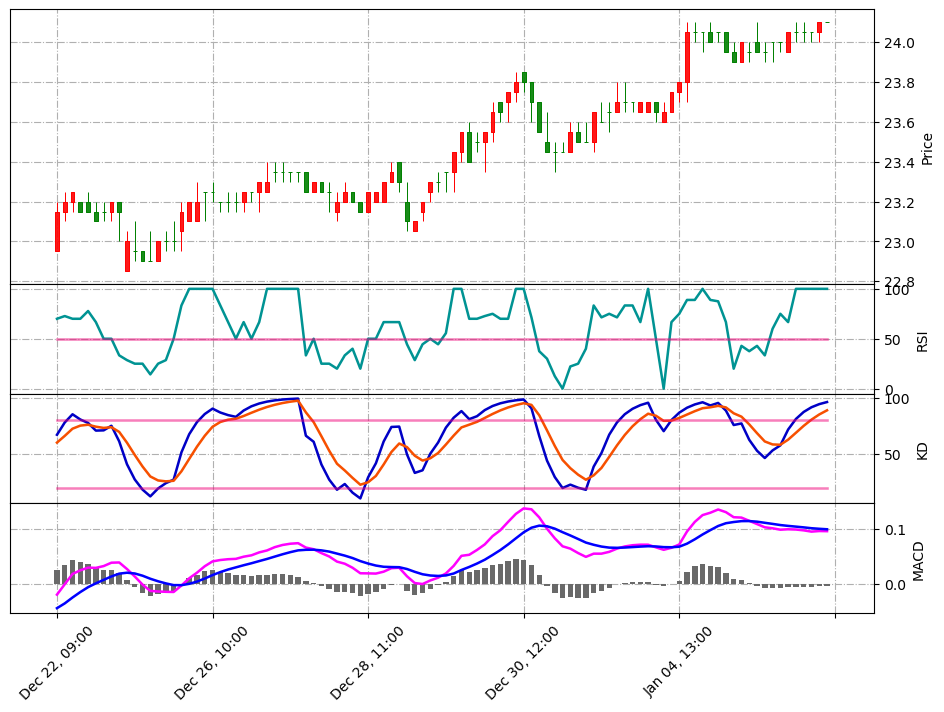

淨收益： NaN 元
投資報酬率： NaN %
勝率 : NaN %
買入持有策略_投資報酬率： 10.05 %
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
                     Open  High   Low  Close  Adj Close  Volume   MA_5  MA_10  \
Datetime                                                                        
2023-01-06 11:30:00  9.96  9.97  9.95   9.95       9.95     318  9.954  9.961   
2023-01-06 12:00:00  9.96  9.96  9.94   9.95       9.95     136  9.950  9.958   
2023-01-06 12:30:00  9.95  9.95  9.93   9.95       9.95     582  9.950  9.954   
2023-01-06 13:00:00  9.94  9.95  9.93   9.94       9.94     293  9.948  9.951   
2023-01-06 13:30:00  9.93  9.93  9.93   9.93       9.93       0  9.944  9.950   

                           RSI          K          D  macd_dif  macd_dem  \
Datetime                                                                   
2023-01-06 11:30:00  60.000000  19.488085  22.551631  0.002502  0.009995

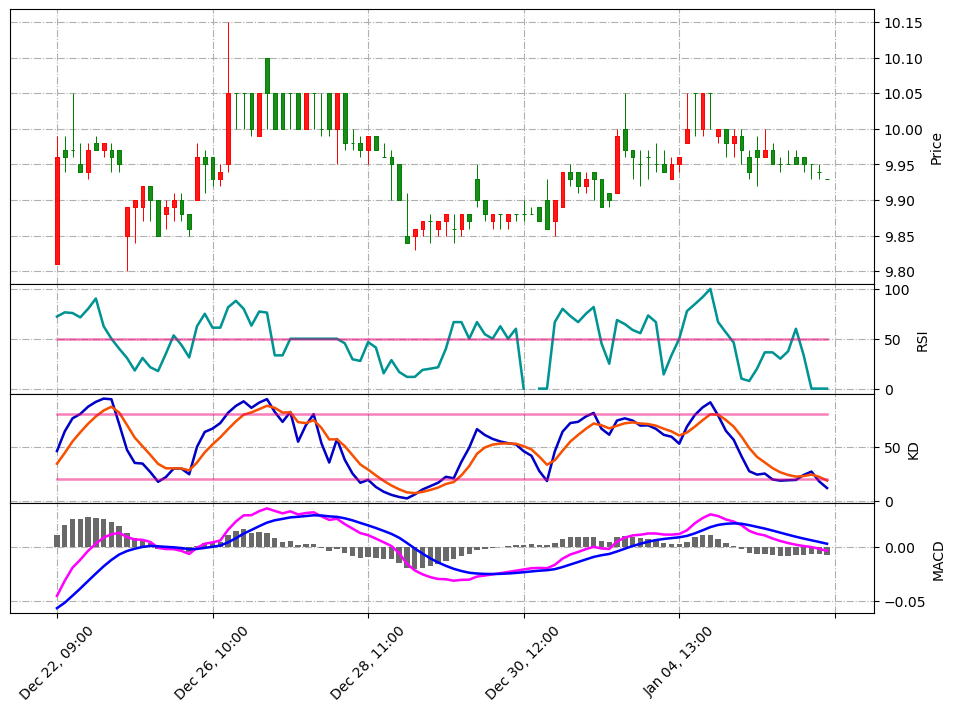

淨收益： -484 元
投資報酬率： -1.61 %
勝率 : 0.0 %
買入持有策略_投資報酬率： 8.17 %
      日期 買/賣(+/-)     價格  價格(稅)   實際花費   目前獲利      此次投報      目前投報
0  12/08       +1  10.00   10.0 -10014 -10014       NaN  1.000000
1  12/08       +1  10.00   10.0 -10014 -20028       NaN  1.000000
2  12/12       +1  10.10   10.1 -10114 -30142       NaN  1.000000
3  01/06       -3   9.93    9.9  29658   -484  0.983943  0.983943
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
                          Open       High        Low      Close  Adj Close  \
Datetime                                                                     
2023-01-06 11:30:00  67.000000  67.000000  66.699997  67.000000  67.000000   
2023-01-06 12:00:00  66.900002  67.099998  66.800003  66.900002  66.900002   
2023-01-06 12:30:00  67.000000  67.000000  66.800003  67.000000  67.000000   
2023-01-06 13:00:00  67.000000  67.000000  66.500000  66.699997  66.69

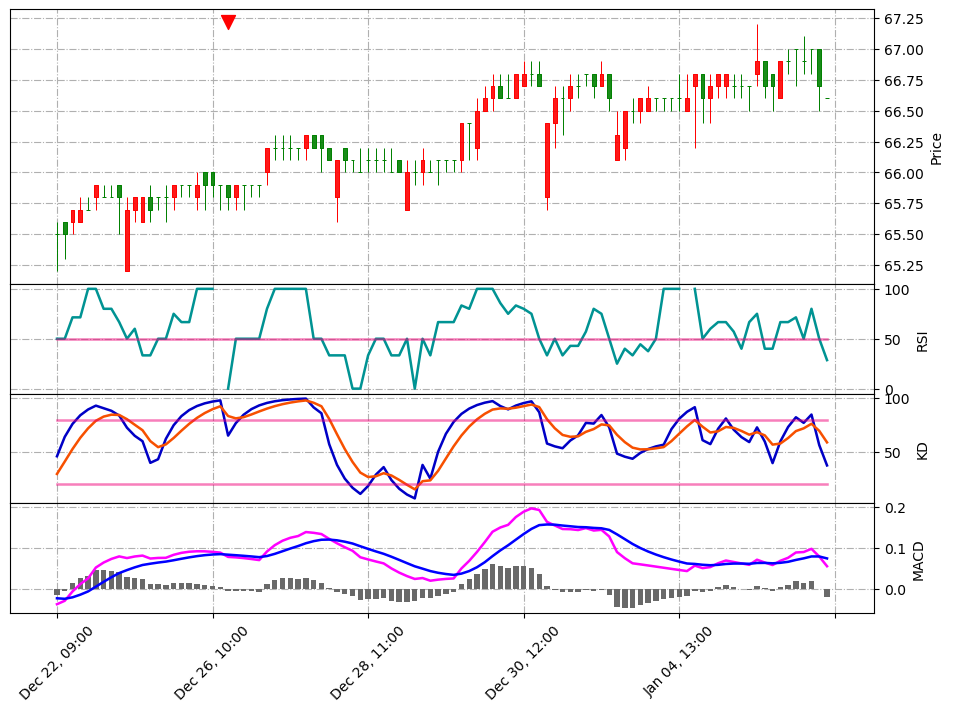

淨收益： NaN 元
投資報酬率： NaN %
勝率 : NaN %
買入持有策略_投資報酬率： 0.76 %
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
                          Open       High        Low      Close  Adj Close  \
Datetime                                                                     
2023-01-06 11:30:00  71.500000  71.500000  71.400002  71.400002  71.400002   
2023-01-06 12:00:00  71.400002  71.599998  71.300003  71.400002  71.400002   
2023-01-06 12:30:00  71.400002  71.400002  71.099998  71.199997  71.199997   
2023-01-06 13:00:00  71.199997  71.300003  71.199997  71.199997  71.199997   
2023-01-06 13:30:00  71.300003  71.300003  71.300003  71.300003  71.300003   

                     Volume       MA_5      MA_10        RSI          K  \
Datetime                                                                  
2023-01-06 11:30:00     138  71.300000  71.120001  87.499404  91.198331   
2023-01-06 12:00:00  

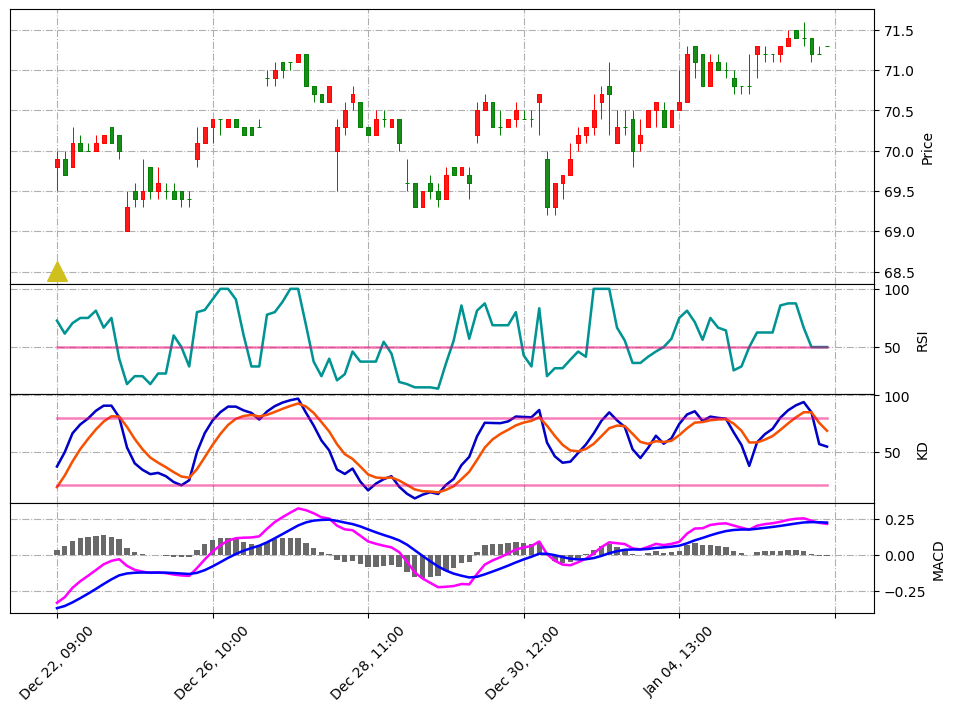

淨收益： 1268 元
投資報酬率： 0.9 %
勝率 : 100.0 %
買入持有策略_投資報酬率： 8.19 %
      日期 買/賣(+/-)         價格  價格(稅)    實際花費    目前獲利      此次投報      目前投報
0  12/12       +1  70.599998   70.7  -70701  -70701       NaN  1.000000
1  12/22       +1  69.900002   70.0  -70000 -140701       NaN  1.000000
2  01/06       -2  71.300003   71.0  141969    1268  1.009012  1.009012
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
                          Open       High        Low  Close  Adj Close  \
Datetime                                                                 
2023-01-06 11:30:00  34.299999  34.299999  34.200001  34.25      34.25   
2023-01-06 12:00:00  34.250000  34.299999  34.200001  34.25      34.25   
2023-01-06 12:30:00  34.299999  34.299999  34.200001  34.25      34.25   
2023-01-06 13:00:00  34.250000  34.299999  34.200001  34.25      34.25   
2023-01-06 13:30:00  34.250000  34.250000  34.250000  34.2

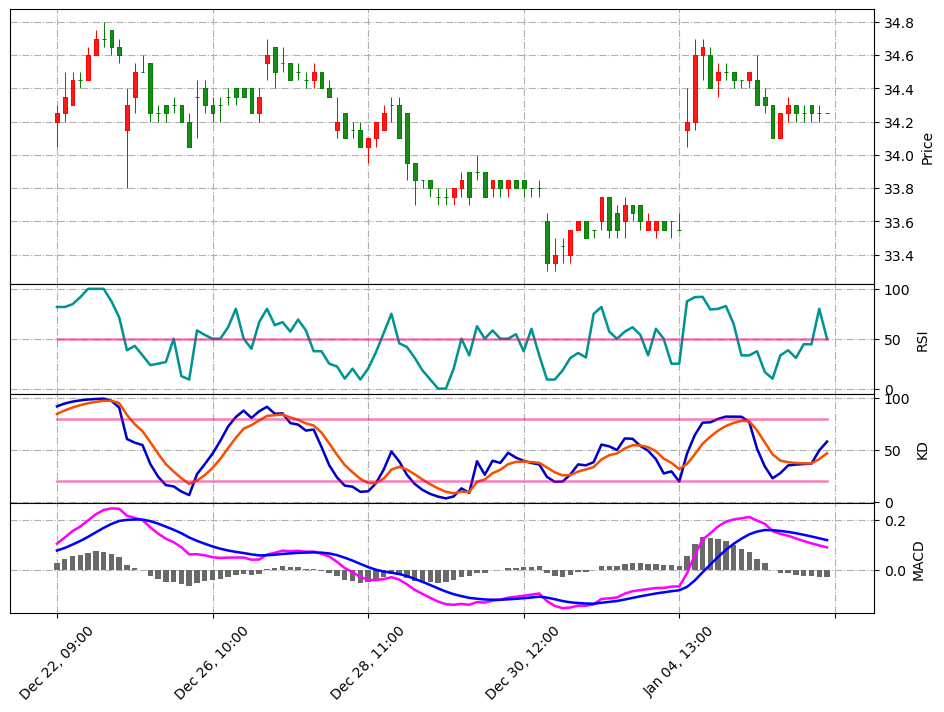

淨收益： NaN 元
投資報酬率： NaN %
勝率 : NaN %
買入持有策略_投資報酬率： 5.22 %
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
                          Open       High        Low      Close  Adj Close  \
Datetime                                                                     
2023-01-06 11:30:00  34.700001  34.700001  34.599998  34.599998  34.599998   
2023-01-06 12:00:00  34.599998  34.650002  34.549999  34.549999  34.549999   
2023-01-06 12:30:00  34.549999  34.750000  34.549999  34.700001  34.700001   
2023-01-06 13:00:00  34.700001  34.750000  34.650002  34.750000  34.750000   
2023-01-06 13:30:00  34.750000  34.750000  34.750000  34.750000  34.750000   

                     Volume   MA_5   MA_10        RSI          K          D  \
Datetime                                                                      
2023-01-06 11:30:00     128  34.56  34.435  78.571234  85.187115  76.319905   
2023-01-0

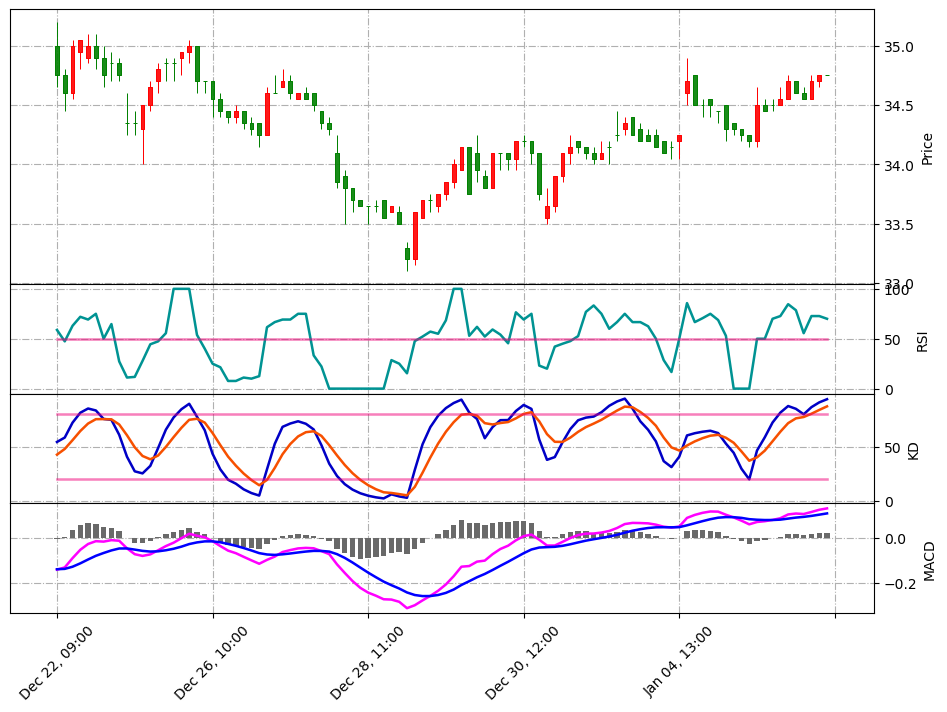

淨收益： 5953 元
投資報酬率： 20.46 %
勝率 : 100.0 %
買入持有策略_投資報酬率： 10.14 %
      日期 買/賣(+/-)         價格  價格(稅)   實際花費   目前獲利      此次投報      目前投報
0  10/31       +1  29.049999   29.1 -29091 -29091       NaN  1.000000
1  12/15       -1  35.200001   35.0  35044   5953  1.204634  1.204634
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
                          Open       High   Low      Close  Adj Close  Volume  \
Datetime                                                                        
2023-01-06 11:30:00  50.099998  50.099998  50.0  50.099998  50.099998      21   
2023-01-06 12:00:00  50.099998  50.099998  50.0  50.000000  50.000000      33   
2023-01-06 12:30:00  50.000000  50.099998  50.0  50.099998  50.099998      43   
2023-01-06 13:00:00  50.099998  50.099998  50.0  50.000000  50.000000      36   
2023-01-06 13:30:00  50.000000  50.000000  50.0  50.000000  50.000000       0   

         

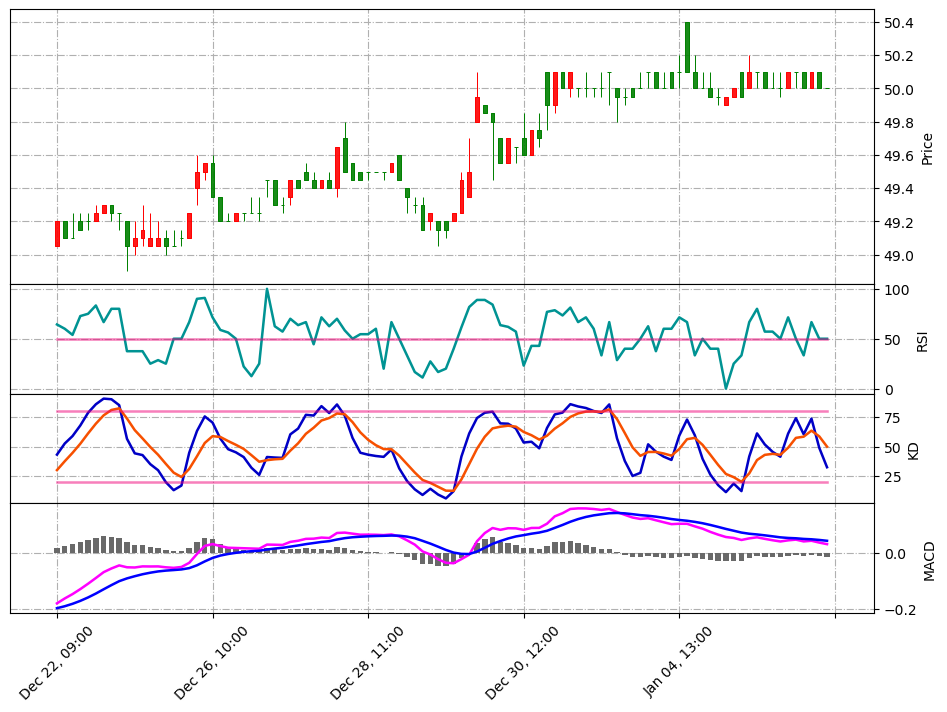

淨收益： 509 元
投資報酬率： 1.03 %
勝率 : 100.0 %
買入持有策略_投資報酬率： 3.52 %
      日期 買/賣(+/-)         價格  價格(稅)   實際花費   目前獲利      此次投報      目前投報
0  11/21       +1  49.200001   49.3 -49270 -49270       NaN  1.000000
1  01/06       -1  50.000000   49.8  49779    509  1.010331  1.010331
---------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
                           Open        High         Low       Close  \
Datetime                                                              
2023-01-06 11:30:00  112.000000  112.099998  111.949997  112.050003   
2023-01-06 12:00:00  112.050003  112.199997  111.949997  112.000000   
2023-01-06 12:30:00  112.050003  112.050003  111.900002  111.949997   
2023-01-06 13:00:00  111.900002  111.949997  111.800003  111.849998   
2023-01-06 13:30:00  111.800003  111.800003  111.800003  111.800003   

                      Adj Close  Volume        MA_5    MA_10        RSI  \
Datetim

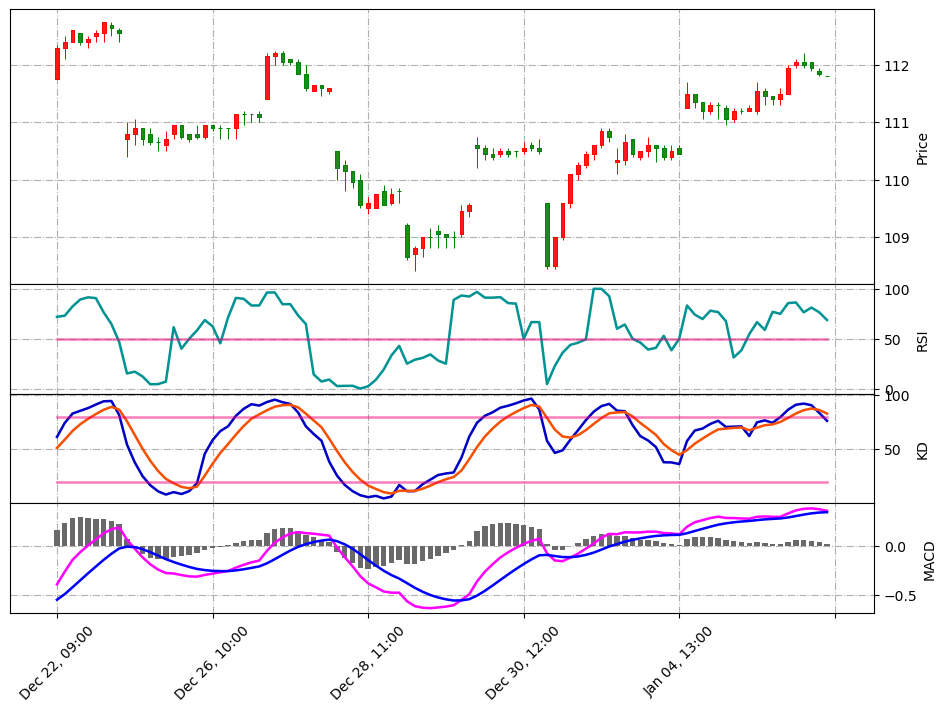

淨收益： NaN 元
投資報酬率： NaN %
勝率 : NaN %
買入持有策略_投資報酬率： 10.47 %
---------------------------------------------------------------------------------


code return rate accuracy Buy&Hold return rate
0   2330.TW       NaN %    NaN %              11.83 %
1   2317.TW     -0.75 %    0.0 %              -5.84 %
2   2409.TW     -0.27 %    0.0 %              -6.73 %
3   1301.TW       NaN %    NaN %              10.28 %
4   2882.TW     -0.52 %    0.0 %                7.1 %
5   2002.TW       NaN %    NaN %              11.25 %
6   2337.TW     20.46 %  100.0 %              10.14 %
7   2308.TW     -4.79 %    0.0 %               0.74 %
8   2353.TW       NaN %    NaN %              10.05 %
9   1314.TW     -1.61 %    0.0 %               8.17 %
10  1216.TW       NaN %    NaN %               0.76 %
11  1326.TW       0.9 %  100.0 %               8.19 %
12  1101.TW       NaN %    NaN %               5.22 %
13  2337.TW     20.46 %  100.0 %              10.14 %
14  1229.TW      1.03 %  100.0 %               3.52 %
15  0050.TW       NaN %    NaN %              10.47 %

In [48]:
ticks = ["2330.TW", "2317.TW", "2409.TW", "1301.TW", "2882.TW", "2002.TW",
        "2337.TW", "2308.TW", "2353.TW", "1314.TW", "1216.TW", "1326.TW", 
        "1101.TW", "2337.TW", "1229.TW","0050.TW"]
df_2  = 完整版實作(ticks,start= None,end=None,period='60d' ,interval='30m')
df_2 

## 總結 - 高頻資料

In [ ]:
df_total_2 = df_add(df_2)
df_total_2

name     code return rate accuracy Buy&Hold return rate industries
0      台積電  2330.TW       NaN %    NaN %              13.54 %       半導體業
1       鴻海  2317.TW     -0.75 %    0.0 %              -5.77 %        電子業
2      宏達電  2409.TW     -2.78 %    0.0 %              -7.72 %      通信網路業
3       台塑  1301.TW       NaN %    NaN %              11.07 %       塑膠工業
4      國泰金  2882.TW     -1.87 %    0.0 %               4.96 %      金融保險業
5       中鋼  2002.TW       NaN %    NaN %               9.71 %       鋼鐵工業
6     奇美電子  2337.TW     20.46 %  100.0 %               9.78 %        光電業
7      台達電  2308.TW     -3.03 %    0.0 %               3.36 %     電子零組件業
8       宏碁  2353.TW       NaN %    NaN %              11.14 %   電腦及週邊設備業
9     台塑石化  1314.TW     -1.51 %    0.0 %               7.93 %      油電燃氣業
10      統一  1216.TW       NaN %    NaN %               1.52 %       食品工業
11     遠東新  1326.TW      0.34 %  100.0 %               7.91 %       紡織纖維
12      台泥  1101.TW       NaN %    NaN %               2.99 %       水泥工業
13    聯強國際  2337.TW     20.46 %  100.0 %               9.78 %      電子通路業
14     統一超  1229.TW      1.23 %  100.0 %               3.09 %       貿易百貨
15  台灣50指數  0050.TW       NaN %    NaN %              11.03 %        ETF

## Q&A

### 為何原本的code，策略顯示是虧錢，但呈現的投資報酬率顯示卻是正的？


### 要如何修正？

### 我們先來看修正前的計算方式

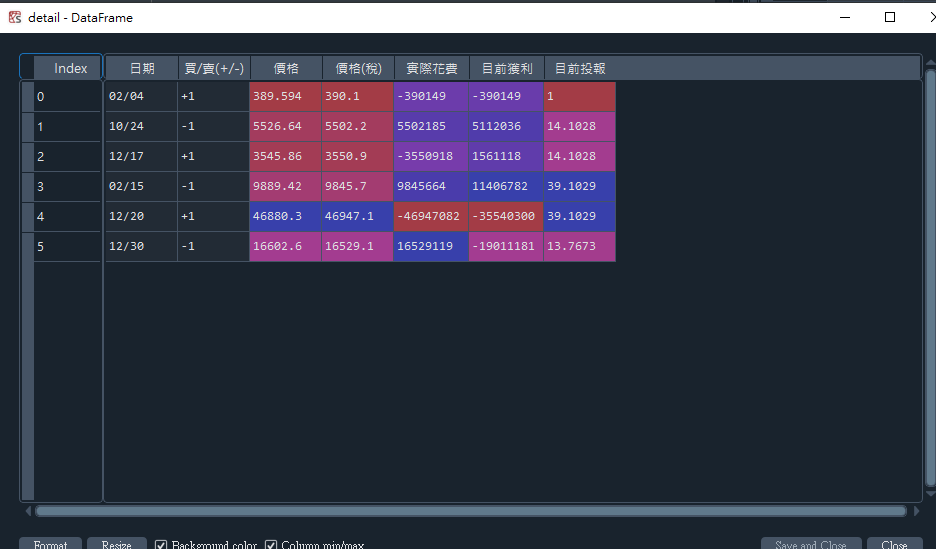

### 我們要修正**回測模塊**中累積報酬率的計算公式
修正後版本如下

In [ ]:
# 回測模塊
def backtest(_ticker):
    # 假設每個買點最多買一張，遇到賣點會將手中持股全數賣出

    # 目前持有數量
    stock_num = 0
    # 每次購入張數
    unit = 1

    # 目前獲利
    gain = 0
    # 目前投資報酬率
    return_rate = 1
    # 為了計算投資報酬率
    balance = 0

    # 為了計算勝率
    make_money = 0
    trade_times = 0

    # 紀錄交易資訊
    detail = [['日期', '買/賣(+/-)', '價格', '價格(稅)', '實際花費', '目前獲利', '此次投報', '目前投報']]

    # 迭帶 SData 中的每一列資料
    for index, row in _ticker.iterrows():

        # 遇到買點就買入一張
        if row['buy'] == 1 and index != _ticker.index[-1]:

            # 日期(會將時間戳記轉為字串，第二個參數可以設定樣式)
            date = datetime.strftime(index, '%m/%d')
            # 買賣數量(將持有股票全部賣出)
            _unit = f'+{unit}'
            # 買入價格(假設為當日盤後買收盤價)
            _price = row['Close']
            # 買入價格(含稅)
            _price_tax = round(row['Close'] * 1.001425, 1)
            # 實際總花費
            total_cost = round(row['Close'] * 1.001425 * unit * 1000) * -1
            # 淨收益計算
            gain += total_cost
            # 更新下次投資報酬之現金平衡
            balance += total_cost
            # 更新持有數量
            stock_num += unit

            # 將此列交易資訊加入 detail 中
            detail.append([date, _unit, _price, _price_tax, total_cost, gain, 'NaN', return_rate])

        # 遇到賣點全數賣出
        # 是最後一天且還持有股票時，無條件賣出，方便計算投資報酬率
        elif (row['sell'] == 1 and stock_num > 0) or (index == _ticker.index[-1] and stock_num > 0):
            
            # 日期(會將時間戳記轉為字串，第二個參數可以設定樣式)
            date = datetime.strftime(index, '%m/%d')
            # 買賣數量(將持有股票全部賣出)
            _unit = f'-{stock_num}'
            # 賣出價格(假設為當日盤後買收盤價)
            _price = row['Close']
            # 賣出價格(含稅)(四捨五入到小術後一位)
            _price_tax = round(row['Close'] * 0.995575, 1)
            # 實際總花費(四捨五入到整數位)
            total_cost = round(row['Close'] * 0.995575 * stock_num * 1000)
            # 淨收益計算
            gain += total_cost
            # 更新投資報酬率
            principal = -balance
            balance += total_cost
            current_return = 1 + (balance / principal)
            return_rate *= 1 + (balance / principal)
            # to calculate accuracy
            trade_times += 1
            if(balance > 0):
                make_money += 1
            # 重製 balance
            balance = 0
            # 更新持有數量
            stock_num = 0
            
            # 將此列交易資訊加入 detail 中
            detail.append([date, _unit, _price, _price_tax, total_cost, gain, current_return, return_rate])

    #新增 買入持有策略績效 - 投資報酬率
    first = _ticker['Close'][0]
    last = _ticker['Close'][len(_ticker)-1]
    cumulative_exret = (last-first)/first
    cumulative_exret = round(cumulative_exret*100 , 2)
    #print("買入持有投資報酬率：", cumulative_exret, "%")     
    
    
    # 淨收益、投資報酬率、
    # print("淨收益：", detail[-1][5], "元")
    # print("投資報酬率：", (return_rate - 1) * 100, "%")
    # if(trade_times != 0):
    #     print('勝率 :', make_money / trade_times * 100, '%')
    if(trade_times != 0):
        acc = make_money / trade_times * 100
    else:
        acc = -1
    return pd.DataFrame(detail[1:], columns=detail[0]), acc, cumulative_exret

### 我們再來看修正後的計算方式

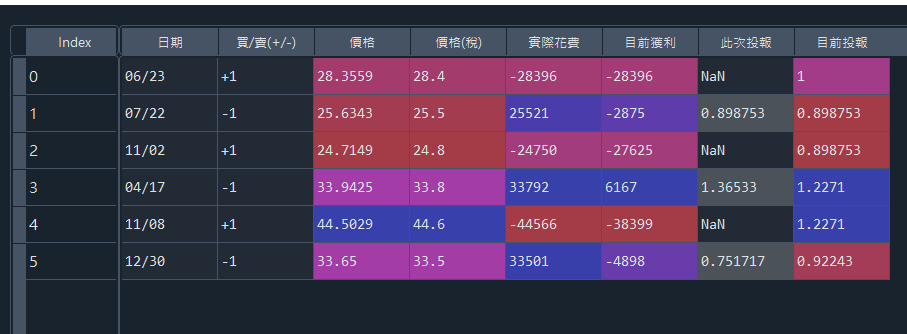